In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
from abc import abstractmethod
from einops import repeat
from functools import partial
from inspect import isfunction

In [22]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [23]:
datapath = "../../../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [24]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [25]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [26]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [27]:
def prepare_data(features):
    sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])
    features_scaled = features_scaled[sensor_columns + ['activity']]
    
    print ("columns : ", features_scaled.columns)
    adl_count = features_scaled['activity'].value_counts()[0]
    fall_count = features_scaled['activity'].value_counts()[1]

    adl_mask = features_scaled['activity'] == 0
    adl_data = features_scaled[adl_mask]
    adl1 = adl_data.iloc[:int(adl_count * 0.8)]
    adl2 = adl_data.iloc[int(adl_count * 0.2):]

    fall_mask = features_scaled['activity'] == 1
    fall_data = features_scaled[fall_mask]
    fall1 = fall_data.iloc[:int(fall_count * 0.8)]
    fall2 = fall_data.iloc[int(fall_count * 0.2):]
    
    train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)
    test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
    test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
    test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)
    
    return train_data, test_adl_data, test_fall1_data, test_fall2_data

In [28]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [29]:
subject_id = 16
dfs_16 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_16.append(df)

features_16 = pd.concat(dfs_16, ignore_index=True)
features_16['activity'] = features_16['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_16 = features_16.dropna()

100%|███████████████████████████████████████| 746/746 [00:00<00:00, 1188.77it/s]


In [30]:
subject_id = 17
dfs_17 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_17.append(df)

features_17 = pd.concat(dfs_17, ignore_index=True)
features_17['activity'] = features_17['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_17 = features_17.dropna()

100%|███████████████████████████████████████| 746/746 [00:00<00:00, 1054.57it/s]


In [31]:
subject_id = 18
dfs_18 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_18.append(df)

features_18 = pd.concat(dfs_18, ignore_index=True)
features_18['activity'] = features_18['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_18 = features_18.dropna()

100%|████████████████████████████████████████| 746/746 [00:05<00:00, 129.94it/s]


In [32]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data_16, test_adl_data_16, test_fall1_data_16, test_fall2_data_16 = prepare_data(features_16)
train_data_17, test_adl_data_17, test_fall1_data_17, test_fall2_data_17 = prepare_data(features_17)
train_data_18, test_adl_data_18, test_fall1_data_18, test_fall2_data_18 = prepare_data(features_18)

columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_

----

In [33]:
EPOCHS = 1000
INITIAL_LEARNING_RATE = 1e-4 
DECAY_STEPS = 1000
DECAY_RATE = 0.98
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

import math
from functools import partial
from inspect import isfunction

In [34]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [35]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                    These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

In [36]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(x)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, 1)

    def forward(self, x, emb):
        return self._forward(x, emb)

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

In [37]:
class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=32,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)

In [38]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps: int = 1000,
        beta_schedule="linear",
        loss_type="l2",
        log_every_t=100,
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
        original_elbo_weight=0.0,
        v_posterior=0.0,
        l_simple_weight=1.0,
        parameterization="eps",
        learn_logvar=False,
        logvar_init=0.0,
    ):
        super().__init__()
        assert parameterization in [
            "eps",
            "x0",
        ], 'currently only supporting "eps" and "x0"'
        self.parameterization = parameterization

        self.model = UNetModel(**unet_config.get("params", dict()))

        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        self.loss_type = loss_type

        self.register_schedule(
            beta_schedule=beta_schedule,
            timesteps=timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(
            fill_value=logvar_init, size=(self.num_timesteps,)
        )
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

    def register_schedule(
        self,
        beta_schedule="linear",
        timesteps=1000,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
    ):
        betas = make_beta_schedule(
            beta_schedule,
            timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer(
            "alphas_cumprod_prev", to_torch(alphas_cumprod_prev)
        )

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            "sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod",
            to_torch(np.sqrt(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod",
            to_torch(np.log(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod - 1)),
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (
            1.0 - alphas_cumprod_prev
        ) / (1.0 - alphas_cumprod) + self.v_posterior * betas
        self.register_buffer(
            "posterior_variance", to_torch(posterior_variance)
        )
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(
                betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
            ),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev)
                * np.sqrt(alphas)
                / (1.0 - alphas_cumprod)
            ),
        )

        if self.parameterization == "eps":
            lvlb_weights = self.betas**2 / (
                2
                * self.posterior_variance
                * to_torch(alphas)
                * (1 - self.alphas_cumprod)
            )
        elif self.parameterization == "x0":
            lvlb_weights = (
                0.5
                * np.sqrt(torch.Tensor(alphas_cumprod))
                / (2.0 * 1 - torch.Tensor(alphas_cumprod))
            )
        else:
            raise NotImplementedError("mu not supported")
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer("lvlb_weights", lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of
        noiseless inputs.
        :param t: the number of diffusion steps (minus 1).
        Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance),
        all of x_start's shape.
        """
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:
            q(x_{t-1} | x_t, x_0)
        """
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return (
            posterior_mean,
            posterior_variance,
            posterior_log_variance_clipped,
        )

    def p_mean_variance(self, x, t, clip_denoised: bool, return_x0=False):
        """
        Apply the model to get p(x_{t-1} | x_t)
        :param model: the model, which takes a signal and a batch of timesteps
                    as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        """
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        (
            model_mean,
            posterior_variance,
            posterior_log_variance,
        ) = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_x0:
            return (
                model_mean,
                posterior_variance,
                posterior_log_variance,
                x_recon,
            )
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(
        self,
        x,
        t,
        clip_denoised=True,
        repeat_noise=False,
        return_x0=False,
        temperature=1.0,
        noise_dropout=0.0,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        """

        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(
            x=x,
            t=t,
            clip_denoised=clip_denoised,
            return_x0=return_x0,
        )
        if return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.0:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(
            b, *((1,) * (len(x.shape) - 1))
        )
        if return_x0:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise,
                x0,
            )
        else:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise
            )

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device

        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]

        for i in tqdm(
            reversed(range(0, self.num_timesteps)),
            desc="sampling loop time step",
            total=self.num_timesteps,
        ):
            img = self.p_sample(
                img,
                torch.full((b,), i, device=device, dtype=torch.long),
                clip_denoised=self.clip_denoised,
            )
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop(
            (batch_size, channels, image_size, image_size),
            return_intermediates=return_intermediates,
        )

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.
        In other words, sample from q(x_t | x_0).
        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here,
        0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == "l1":
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == "l2":
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(
                    target, pred, reduction="none"
                )
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(
                f"Paramterization {self.parameterization} not yet supported"
            )

        loss_simple = self.get_loss(model_output, target, mean=False).mean(
            dim=[1, 2]
        )
        loss_dict.update({f"loss_simple": loss_simple.mean()})

        logvar_t = self.logvar[t].to(x_start.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        if self.learn_logvar:
            loss_dict.update({f"loss_gamma": loss.mean()})
            loss_dict.update({"logvar": self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(
            dim=(1, 2)
        )
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f"loss_vlb": loss_vlb})
        loss += self.original_elbo_weight * loss_vlb
        loss_dict.update({f"loss": loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        t = torch.randint(
            0, self.num_timesteps, (x.shape[0],), device=x.device
        ).long()
        return self.p_losses(x, t, *args, **kwargs)

    def configure_optimizers(self):
        self.learning_rate = 1e-4
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            print("Diffusion model optimizing logvar")
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        return opt

In [39]:
def train_ddpm_ppg(model, train_loader, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        pbar = tqdm(enumerate(train_loader), 
                   desc=f'Epoch {epoch+1}/{num_epochs}', 
                   total=n_batches,
                   leave=False)
        
        for i, batch in pbar:
            optimizer.zero_grad()
            x = batch.to(device)
            loss, loss_dict = model(x)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [40]:
unet_config = {
    "params": {
        "image_size": 40, 
        "in_channels": 39, 
        "model_channels": 32,
        "out_channels": 39,
        "num_res_blocks": 2,
        "attention_resolutions": [10, 5],
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
        "use_scale_shift_norm": True
    }
}

ddpm1 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer1 = ddpm1.configure_optimizers()

print("\nSubject 16 Training:")
train_dataset_16 = UMAFallDataset(train_data_16)
train_loader_16 = DataLoader(train_dataset_16, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm1, train_loader_16, optimizer1, EPOCHS, device)


Subject 16 Training:


Epoch 1/1000 - Avg Loss: 0.9985


Epoch 2/1000 - Avg Loss: 1.0076


Epoch 3/1000 - Avg Loss: 0.9988


Epoch 4/1000 - Avg Loss: 0.9939


Epoch 5/1000 - Avg Loss: 0.9818


Epoch 6/1000 - Avg Loss: 0.9854


Epoch 7/1000 - Avg Loss: 0.9852


Epoch 8/1000 - Avg Loss: 0.9823


Epoch 9/1000 - Avg Loss: 0.9884


Epoch 10/1000 - Avg Loss: 0.9834


Epoch 11/1000 - Avg Loss: 0.9841


Epoch 12/1000 - Avg Loss: 0.9763


Epoch 13/1000 - Avg Loss: 0.9711


Epoch 14/1000 - Avg Loss: 0.9755


Epoch 15/1000 - Avg Loss: 0.9701


Epoch 16/1000 - Avg Loss: 0.9712


Epoch 17/1000 - Avg Loss: 0.9651


Epoch 18/1000 - Avg Loss: 0.9661


Epoch 19/1000 - Avg Loss: 0.9677


Epoch 20/1000 - Avg Loss: 0.9662


Epoch 21/1000 - Avg Loss: 0.9569


Epoch 22/1000 - Avg Loss: 0.9563


Epoch 23/1000 - Avg Loss: 0.9515


Epoch 24/1000 - Avg Loss: 0.9586


Epoch 25/1000 - Avg Loss: 0.9581


Epoch 26/1000 - Avg Loss: 0.9457


Epoch 27/1000 - Avg Loss: 0.9469


Epoch 28/1000 - Avg Loss: 0.9430


Epoch 29/1000 - Avg Loss: 0.9461


Epoch 30/1000 - Avg Loss: 0.9399


Epoch 31/1000 - Avg Loss: 0.9458


Epoch 32/1000 - Avg Loss: 0.9411


Epoch 33/1000 - Avg Loss: 0.9401


Epoch 34/1000 - Avg Loss: 0.9299


Epoch 35/1000 - Avg Loss: 0.9308


Epoch 36/1000 - Avg Loss: 0.9298


Epoch 37/1000 - Avg Loss: 0.9249


Epoch 38/1000 - Avg Loss: 0.9265


Epoch 39/1000 - Avg Loss: 0.9225


Epoch 40/1000 - Avg Loss: 0.9198


Epoch 41/1000 - Avg Loss: 0.9155


Epoch 42/1000 - Avg Loss: 0.9150


Epoch 43/1000 - Avg Loss: 0.9124


Epoch 44/1000 - Avg Loss: 0.9128


Epoch 45/1000 - Avg Loss: 0.9080


Epoch 46/1000 - Avg Loss: 0.9192


Epoch 47/1000 - Avg Loss: 0.9169


Epoch 48/1000 - Avg Loss: 0.9119


Epoch 49/1000 - Avg Loss: 0.9002


Epoch 50/1000 - Avg Loss: 0.8989


Epoch 51/1000 - Avg Loss: 0.8950


Epoch 52/1000 - Avg Loss: 0.8993


Epoch 53/1000 - Avg Loss: 0.9000


Epoch 54/1000 - Avg Loss: 0.8901


Epoch 55/1000 - Avg Loss: 0.8844


Epoch 56/1000 - Avg Loss: 0.8799


Epoch 57/1000 - Avg Loss: 0.8843


Epoch 58/1000 - Avg Loss: 0.8900


Epoch 59/1000 - Avg Loss: 0.8815


Epoch 60/1000 - Avg Loss: 0.8769


Epoch 61/1000 - Avg Loss: 0.8685


Epoch 62/1000 - Avg Loss: 0.8731


Epoch 63/1000 - Avg Loss: 0.8820


Epoch 64/1000 - Avg Loss: 0.8787


Epoch 65/1000 - Avg Loss: 0.8751


Epoch 66/1000 - Avg Loss: 0.8791


Epoch 67/1000 - Avg Loss: 0.8753


Epoch 68/1000 - Avg Loss: 0.8629


Epoch 69/1000 - Avg Loss: 0.8597


Epoch 70/1000 - Avg Loss: 0.8648


Epoch 71/1000 - Avg Loss: 0.8595


Epoch 72/1000 - Avg Loss: 0.8612


Epoch 73/1000 - Avg Loss: 0.8549


Epoch 74/1000 - Avg Loss: 0.8537


Epoch 75/1000 - Avg Loss: 0.8525


Epoch 76/1000 - Avg Loss: 0.8450


Epoch 77/1000 - Avg Loss: 0.8549


Epoch 78/1000 - Avg Loss: 0.8548


Epoch 79/1000 - Avg Loss: 0.8380


Epoch 80/1000 - Avg Loss: 0.8454


Epoch 81/1000 - Avg Loss: 0.8440


Epoch 82/1000 - Avg Loss: 0.8486


Epoch 83/1000 - Avg Loss: 0.8396


Epoch 84/1000 - Avg Loss: 0.8451


Epoch 85/1000 - Avg Loss: 0.8397


Epoch 86/1000 - Avg Loss: 0.8468


Epoch 87/1000 - Avg Loss: 0.8335


Epoch 88/1000 - Avg Loss: 0.8236


Epoch 89/1000 - Avg Loss: 0.8401


Epoch 90/1000 - Avg Loss: 0.8357


Epoch 91/1000 - Avg Loss: 0.8412


Epoch 92/1000 - Avg Loss: 0.8239


Epoch 93/1000 - Avg Loss: 0.8195


Epoch 94/1000 - Avg Loss: 0.8271


Epoch 95/1000 - Avg Loss: 0.8157


Epoch 96/1000 - Avg Loss: 0.8213


Epoch 97/1000 - Avg Loss: 0.8223


Epoch 98/1000 - Avg Loss: 0.8060


Epoch 99/1000 - Avg Loss: 0.7979


Epoch 100/1000 - Avg Loss: 0.8087


Epoch 101/1000 - Avg Loss: 0.7995


Epoch 102/1000 - Avg Loss: 0.8046


Epoch 103/1000 - Avg Loss: 0.8189


Epoch 104/1000 - Avg Loss: 0.8019


Epoch 105/1000 - Avg Loss: 0.8156


Epoch 106/1000 - Avg Loss: 0.7972


Epoch 107/1000 - Avg Loss: 0.8053


Epoch 108/1000 - Avg Loss: 0.7896


Epoch 109/1000 - Avg Loss: 0.8016


Epoch 110/1000 - Avg Loss: 0.7952


Epoch 111/1000 - Avg Loss: 0.8058


Epoch 112/1000 - Avg Loss: 0.7751


Epoch 113/1000 - Avg Loss: 0.7999


Epoch 114/1000 - Avg Loss: 0.7859


Epoch 115/1000 - Avg Loss: 0.7926


Epoch 116/1000 - Avg Loss: 0.7999


Epoch 117/1000 - Avg Loss: 0.7747


Epoch 118/1000 - Avg Loss: 0.8053


Epoch 119/1000 - Avg Loss: 0.7709


Epoch 120/1000 - Avg Loss: 0.7846


Epoch 121/1000 - Avg Loss: 0.7975


Epoch 122/1000 - Avg Loss: 0.7507


Epoch 123/1000 - Avg Loss: 0.7563


Epoch 124/1000 - Avg Loss: 0.7673


Epoch 125/1000 - Avg Loss: 0.7689


Epoch 126/1000 - Avg Loss: 0.7850


Epoch 127/1000 - Avg Loss: 0.7840


Epoch 128/1000 - Avg Loss: 0.7682


Epoch 129/1000 - Avg Loss: 0.7562


Epoch 130/1000 - Avg Loss: 0.7643


Epoch 131/1000 - Avg Loss: 0.7741


Epoch 132/1000 - Avg Loss: 0.7572


Epoch 133/1000 - Avg Loss: 0.7442


Epoch 134/1000 - Avg Loss: 0.7441


Epoch 135/1000 - Avg Loss: 0.7747


Epoch 136/1000 - Avg Loss: 0.7446


Epoch 137/1000 - Avg Loss: 0.7634


Epoch 138/1000 - Avg Loss: 0.7548


Epoch 139/1000 - Avg Loss: 0.7537


Epoch 140/1000 - Avg Loss: 0.7378


Epoch 141/1000 - Avg Loss: 0.7362


Epoch 142/1000 - Avg Loss: 0.7300


Epoch 143/1000 - Avg Loss: 0.7232


Epoch 144/1000 - Avg Loss: 0.7429


Epoch 145/1000 - Avg Loss: 0.7482


Epoch 146/1000 - Avg Loss: 0.7473


Epoch 147/1000 - Avg Loss: 0.7298


Epoch 148/1000 - Avg Loss: 0.7433


Epoch 149/1000 - Avg Loss: 0.7369


Epoch 150/1000 - Avg Loss: 0.7389


Epoch 151/1000 - Avg Loss: 0.7181


Epoch 152/1000 - Avg Loss: 0.7175


Epoch 153/1000 - Avg Loss: 0.7332


Epoch 154/1000 - Avg Loss: 0.7401


Epoch 155/1000 - Avg Loss: 0.7235


Epoch 156/1000 - Avg Loss: 0.7387


Epoch 157/1000 - Avg Loss: 0.7081


Epoch 158/1000 - Avg Loss: 0.7315


Epoch 159/1000 - Avg Loss: 0.7254


Epoch 160/1000 - Avg Loss: 0.7108


Epoch 161/1000 - Avg Loss: 0.7166


Epoch 162/1000 - Avg Loss: 0.7224


Epoch 163/1000 - Avg Loss: 0.7278


Epoch 164/1000 - Avg Loss: 0.7060


Epoch 165/1000 - Avg Loss: 0.7190


Epoch 166/1000 - Avg Loss: 0.7139


Epoch 167/1000 - Avg Loss: 0.7126


Epoch 168/1000 - Avg Loss: 0.7039


Epoch 169/1000 - Avg Loss: 0.7089


Epoch 170/1000 - Avg Loss: 0.7021


Epoch 171/1000 - Avg Loss: 0.7125


Epoch 172/1000 - Avg Loss: 0.6834


Epoch 173/1000 - Avg Loss: 0.7238


Epoch 174/1000 - Avg Loss: 0.6988


Epoch 175/1000 - Avg Loss: 0.7012


Epoch 176/1000 - Avg Loss: 0.6865


Epoch 177/1000 - Avg Loss: 0.6808


Epoch 178/1000 - Avg Loss: 0.6916


Epoch 179/1000 - Avg Loss: 0.6938


Epoch 180/1000 - Avg Loss: 0.6899


Epoch 181/1000 - Avg Loss: 0.6822


Epoch 182/1000 - Avg Loss: 0.6821


Epoch 183/1000 - Avg Loss: 0.6896


Epoch 184/1000 - Avg Loss: 0.6837


Epoch 185/1000 - Avg Loss: 0.6887


Epoch 186/1000 - Avg Loss: 0.6784


Epoch 187/1000 - Avg Loss: 0.6989


Epoch 188/1000 - Avg Loss: 0.6851


Epoch 189/1000 - Avg Loss: 0.6871


Epoch 190/1000 - Avg Loss: 0.6783


Epoch 191/1000 - Avg Loss: 0.6795


Epoch 192/1000 - Avg Loss: 0.6863


Epoch 193/1000 - Avg Loss: 0.6782


Epoch 194/1000 - Avg Loss: 0.6803


Epoch 195/1000 - Avg Loss: 0.7078


Epoch 196/1000 - Avg Loss: 0.6664


Epoch 197/1000 - Avg Loss: 0.6535


Epoch 198/1000 - Avg Loss: 0.6677


Epoch 199/1000 - Avg Loss: 0.6734


Epoch 200/1000 - Avg Loss: 0.6873


Epoch 201/1000 - Avg Loss: 0.6629


Epoch 202/1000 - Avg Loss: 0.6842


Epoch 203/1000 - Avg Loss: 0.6733


Epoch 204/1000 - Avg Loss: 0.6763


Epoch 205/1000 - Avg Loss: 0.6827


Epoch 206/1000 - Avg Loss: 0.6559


Epoch 207/1000 - Avg Loss: 0.6556


Epoch 208/1000 - Avg Loss: 0.6572


Epoch 209/1000 - Avg Loss: 0.6343


Epoch 210/1000 - Avg Loss: 0.6669


Epoch 211/1000 - Avg Loss: 0.6578


Epoch 212/1000 - Avg Loss: 0.6835


Epoch 213/1000 - Avg Loss: 0.6639


Epoch 214/1000 - Avg Loss: 0.6469


Epoch 215/1000 - Avg Loss: 0.6475


Epoch 216/1000 - Avg Loss: 0.6627


Epoch 217/1000 - Avg Loss: 0.6462


Epoch 218/1000 - Avg Loss: 0.6370


Epoch 219/1000 - Avg Loss: 0.6477


Epoch 220/1000 - Avg Loss: 0.6326


Epoch 221/1000 - Avg Loss: 0.6324


Epoch 222/1000 - Avg Loss: 0.6658


Epoch 223/1000 - Avg Loss: 0.6461


Epoch 224/1000 - Avg Loss: 0.6466


Epoch 225/1000 - Avg Loss: 0.6324


Epoch 226/1000 - Avg Loss: 0.6252


Epoch 227/1000 - Avg Loss: 0.6190


Epoch 228/1000 - Avg Loss: 0.6715


Epoch 229/1000 - Avg Loss: 0.6363


Epoch 230/1000 - Avg Loss: 0.6403


Epoch 231/1000 - Avg Loss: 0.6385


Epoch 232/1000 - Avg Loss: 0.6547


Epoch 233/1000 - Avg Loss: 0.6272


Epoch 234/1000 - Avg Loss: 0.6396


Epoch 235/1000 - Avg Loss: 0.6260


Epoch 236/1000 - Avg Loss: 0.6185


Epoch 237/1000 - Avg Loss: 0.6214


Epoch 238/1000 - Avg Loss: 0.6574


Epoch 239/1000 - Avg Loss: 0.6341


Epoch 240/1000 - Avg Loss: 0.6002


Epoch 241/1000 - Avg Loss: 0.6395


Epoch 242/1000 - Avg Loss: 0.6349


Epoch 243/1000 - Avg Loss: 0.6228


Epoch 244/1000 - Avg Loss: 0.6156


Epoch 245/1000 - Avg Loss: 0.6195


Epoch 246/1000 - Avg Loss: 0.6143


Epoch 247/1000 - Avg Loss: 0.6149


Epoch 248/1000 - Avg Loss: 0.6187


Epoch 249/1000 - Avg Loss: 0.6227


Epoch 250/1000 - Avg Loss: 0.6155


Epoch 251/1000 - Avg Loss: 0.6100


Epoch 252/1000 - Avg Loss: 0.6127


Epoch 253/1000 - Avg Loss: 0.6126


Epoch 254/1000 - Avg Loss: 0.5909


Epoch 255/1000 - Avg Loss: 0.6195


Epoch 256/1000 - Avg Loss: 0.6138


Epoch 257/1000 - Avg Loss: 0.5965


Epoch 258/1000 - Avg Loss: 0.6201


Epoch 259/1000 - Avg Loss: 0.5765


Epoch 260/1000 - Avg Loss: 0.6179


Epoch 261/1000 - Avg Loss: 0.6202


Epoch 262/1000 - Avg Loss: 0.6162


Epoch 263/1000 - Avg Loss: 0.6195


Epoch 264/1000 - Avg Loss: 0.5945


Epoch 265/1000 - Avg Loss: 0.5938


Epoch 266/1000 - Avg Loss: 0.6144


Epoch 267/1000 - Avg Loss: 0.5913


Epoch 268/1000 - Avg Loss: 0.6071


Epoch 269/1000 - Avg Loss: 0.5929


Epoch 270/1000 - Avg Loss: 0.5967


Epoch 271/1000 - Avg Loss: 0.6321


Epoch 272/1000 - Avg Loss: 0.5995


Epoch 273/1000 - Avg Loss: 0.5923


Epoch 274/1000 - Avg Loss: 0.6025


Epoch 275/1000 - Avg Loss: 0.5892


Epoch 276/1000 - Avg Loss: 0.5637


Epoch 277/1000 - Avg Loss: 0.6244


Epoch 278/1000 - Avg Loss: 0.5783


Epoch 279/1000 - Avg Loss: 0.5736


Epoch 280/1000 - Avg Loss: 0.6099


Epoch 281/1000 - Avg Loss: 0.5908


Epoch 282/1000 - Avg Loss: 0.5968


Epoch 283/1000 - Avg Loss: 0.5783


Epoch 284/1000 - Avg Loss: 0.6125


Epoch 285/1000 - Avg Loss: 0.5891


Epoch 286/1000 - Avg Loss: 0.5914


Epoch 287/1000 - Avg Loss: 0.6034


Epoch 288/1000 - Avg Loss: 0.5883


Epoch 289/1000 - Avg Loss: 0.5786


Epoch 290/1000 - Avg Loss: 0.5726


Epoch 291/1000 - Avg Loss: 0.5834


Epoch 292/1000 - Avg Loss: 0.5562


Epoch 293/1000 - Avg Loss: 0.5770


Epoch 294/1000 - Avg Loss: 0.5896


Epoch 295/1000 - Avg Loss: 0.5518


Epoch 296/1000 - Avg Loss: 0.5786


Epoch 297/1000 - Avg Loss: 0.5755


Epoch 298/1000 - Avg Loss: 0.5914


Epoch 299/1000 - Avg Loss: 0.5496


Epoch 300/1000 - Avg Loss: 0.5450


Epoch 301/1000 - Avg Loss: 0.5458


Epoch 302/1000 - Avg Loss: 0.5704


Epoch 303/1000 - Avg Loss: 0.5696


Epoch 304/1000 - Avg Loss: 0.5595


Epoch 305/1000 - Avg Loss: 0.5851


Epoch 306/1000 - Avg Loss: 0.5587


Epoch 307/1000 - Avg Loss: 0.5518


Epoch 308/1000 - Avg Loss: 0.5810


Epoch 309/1000 - Avg Loss: 0.5500


Epoch 310/1000 - Avg Loss: 0.5527


Epoch 311/1000 - Avg Loss: 0.5771


Epoch 312/1000 - Avg Loss: 0.5534


Epoch 313/1000 - Avg Loss: 0.5476


Epoch 314/1000 - Avg Loss: 0.5584


Epoch 315/1000 - Avg Loss: 0.5466


Epoch 316/1000 - Avg Loss: 0.5696


Epoch 317/1000 - Avg Loss: 0.5401


Epoch 318/1000 - Avg Loss: 0.5458


Epoch 319/1000 - Avg Loss: 0.5818


Epoch 320/1000 - Avg Loss: 0.5418


Epoch 321/1000 - Avg Loss: 0.5599


Epoch 322/1000 - Avg Loss: 0.5656


Epoch 323/1000 - Avg Loss: 0.5303


Epoch 324/1000 - Avg Loss: 0.5303


Epoch 325/1000 - Avg Loss: 0.5331


Epoch 326/1000 - Avg Loss: 0.5654


Epoch 327/1000 - Avg Loss: 0.5534


Epoch 328/1000 - Avg Loss: 0.5593


Epoch 329/1000 - Avg Loss: 0.5561


Epoch 330/1000 - Avg Loss: 0.5202


Epoch 331/1000 - Avg Loss: 0.5572


Epoch 332/1000 - Avg Loss: 0.5331


Epoch 333/1000 - Avg Loss: 0.5468


Epoch 334/1000 - Avg Loss: 0.5371


Epoch 335/1000 - Avg Loss: 0.5805


Epoch 336/1000 - Avg Loss: 0.5535


Epoch 337/1000 - Avg Loss: 0.5877


Epoch 338/1000 - Avg Loss: 0.5401


Epoch 339/1000 - Avg Loss: 0.5392


Epoch 340/1000 - Avg Loss: 0.5471


Epoch 341/1000 - Avg Loss: 0.5219


Epoch 342/1000 - Avg Loss: 0.5489


Epoch 343/1000 - Avg Loss: 0.5372


Epoch 344/1000 - Avg Loss: 0.5667


Epoch 345/1000 - Avg Loss: 0.5187


Epoch 346/1000 - Avg Loss: 0.5253


Epoch 347/1000 - Avg Loss: 0.5205


Epoch 348/1000 - Avg Loss: 0.5474


Epoch 349/1000 - Avg Loss: 0.5206


Epoch 350/1000 - Avg Loss: 0.4941


Epoch 351/1000 - Avg Loss: 0.5255


Epoch 352/1000 - Avg Loss: 0.5371


Epoch 353/1000 - Avg Loss: 0.5273


Epoch 354/1000 - Avg Loss: 0.5243


Epoch 355/1000 - Avg Loss: 0.5251


Epoch 356/1000 - Avg Loss: 0.5824


Epoch 357/1000 - Avg Loss: 0.5356


Epoch 358/1000 - Avg Loss: 0.5042


Epoch 359/1000 - Avg Loss: 0.4893


Epoch 360/1000 - Avg Loss: 0.5187


Epoch 361/1000 - Avg Loss: 0.5545


Epoch 362/1000 - Avg Loss: 0.5325


Epoch 363/1000 - Avg Loss: 0.5122


Epoch 364/1000 - Avg Loss: 0.5387


Epoch 365/1000 - Avg Loss: 0.4918


Epoch 366/1000 - Avg Loss: 0.5230


Epoch 367/1000 - Avg Loss: 0.4908


Epoch 368/1000 - Avg Loss: 0.5324


Epoch 369/1000 - Avg Loss: 0.5306


Epoch 370/1000 - Avg Loss: 0.5092


Epoch 371/1000 - Avg Loss: 0.5624


Epoch 372/1000 - Avg Loss: 0.5046


Epoch 373/1000 - Avg Loss: 0.5315


Epoch 374/1000 - Avg Loss: 0.5035


Epoch 375/1000 - Avg Loss: 0.5091


Epoch 376/1000 - Avg Loss: 0.5307


Epoch 377/1000 - Avg Loss: 0.4935


Epoch 378/1000 - Avg Loss: 0.5441


Epoch 379/1000 - Avg Loss: 0.4842


Epoch 380/1000 - Avg Loss: 0.5008


Epoch 381/1000 - Avg Loss: 0.4782


Epoch 382/1000 - Avg Loss: 0.4865


Epoch 383/1000 - Avg Loss: 0.5313


Epoch 384/1000 - Avg Loss: 0.5414


Epoch 385/1000 - Avg Loss: 0.5037


Epoch 386/1000 - Avg Loss: 0.4813


Epoch 387/1000 - Avg Loss: 0.5367


Epoch 388/1000 - Avg Loss: 0.5177


Epoch 389/1000 - Avg Loss: 0.5026


Epoch 390/1000 - Avg Loss: 0.5062


Epoch 391/1000 - Avg Loss: 0.4983


Epoch 392/1000 - Avg Loss: 0.4858


Epoch 393/1000 - Avg Loss: 0.4839


Epoch 394/1000 - Avg Loss: 0.4956


Epoch 395/1000 - Avg Loss: 0.5134


Epoch 396/1000 - Avg Loss: 0.4804


Epoch 397/1000 - Avg Loss: 0.5074


Epoch 398/1000 - Avg Loss: 0.5094


Epoch 399/1000 - Avg Loss: 0.5183


Epoch 400/1000 - Avg Loss: 0.5138


Epoch 401/1000 - Avg Loss: 0.4988


Epoch 402/1000 - Avg Loss: 0.4958


Epoch 403/1000 - Avg Loss: 0.4906


Epoch 404/1000 - Avg Loss: 0.5050


Epoch 405/1000 - Avg Loss: 0.4898


Epoch 406/1000 - Avg Loss: 0.4782


Epoch 407/1000 - Avg Loss: 0.4618


Epoch 408/1000 - Avg Loss: 0.4747


Epoch 409/1000 - Avg Loss: 0.4828


Epoch 410/1000 - Avg Loss: 0.4866


Epoch 411/1000 - Avg Loss: 0.4916


Epoch 412/1000 - Avg Loss: 0.4557


Epoch 413/1000 - Avg Loss: 0.4622


Epoch 414/1000 - Avg Loss: 0.4968


Epoch 415/1000 - Avg Loss: 0.4610


Epoch 416/1000 - Avg Loss: 0.4691


Epoch 417/1000 - Avg Loss: 0.4727


Epoch 418/1000 - Avg Loss: 0.4779


Epoch 419/1000 - Avg Loss: 0.4912


Epoch 420/1000 - Avg Loss: 0.4684


Epoch 421/1000 - Avg Loss: 0.4939


Epoch 422/1000 - Avg Loss: 0.4620


Epoch 423/1000 - Avg Loss: 0.4758


Epoch 424/1000 - Avg Loss: 0.4953


Epoch 425/1000 - Avg Loss: 0.5135


Epoch 426/1000 - Avg Loss: 0.4674


Epoch 427/1000 - Avg Loss: 0.4628


Epoch 428/1000 - Avg Loss: 0.4947


Epoch 429/1000 - Avg Loss: 0.4479


Epoch 430/1000 - Avg Loss: 0.4635


Epoch 431/1000 - Avg Loss: 0.4784


Epoch 432/1000 - Avg Loss: 0.4780


Epoch 433/1000 - Avg Loss: 0.4598


Epoch 434/1000 - Avg Loss: 0.4719


Epoch 435/1000 - Avg Loss: 0.5266


Epoch 436/1000 - Avg Loss: 0.4773


Epoch 437/1000 - Avg Loss: 0.4748


Epoch 438/1000 - Avg Loss: 0.4974


Epoch 439/1000 - Avg Loss: 0.4653


Epoch 440/1000 - Avg Loss: 0.4486


Epoch 441/1000 - Avg Loss: 0.4602


Epoch 442/1000 - Avg Loss: 0.4580


Epoch 443/1000 - Avg Loss: 0.5030


Epoch 444/1000 - Avg Loss: 0.4566


Epoch 445/1000 - Avg Loss: 0.4583


Epoch 446/1000 - Avg Loss: 0.4570


Epoch 447/1000 - Avg Loss: 0.4628


Epoch 448/1000 - Avg Loss: 0.4737


Epoch 449/1000 - Avg Loss: 0.4536


Epoch 450/1000 - Avg Loss: 0.4768


Epoch 451/1000 - Avg Loss: 0.4855


Epoch 452/1000 - Avg Loss: 0.4616


Epoch 453/1000 - Avg Loss: 0.4325


Epoch 454/1000 - Avg Loss: 0.4427


Epoch 455/1000 - Avg Loss: 0.4658


Epoch 456/1000 - Avg Loss: 0.4313


Epoch 457/1000 - Avg Loss: 0.4536


Epoch 458/1000 - Avg Loss: 0.4536


Epoch 459/1000 - Avg Loss: 0.4762


Epoch 460/1000 - Avg Loss: 0.4723


Epoch 461/1000 - Avg Loss: 0.4860


Epoch 462/1000 - Avg Loss: 0.4716


Epoch 463/1000 - Avg Loss: 0.4452


Epoch 464/1000 - Avg Loss: 0.4943


Epoch 465/1000 - Avg Loss: 0.4554


Epoch 466/1000 - Avg Loss: 0.4730


Epoch 467/1000 - Avg Loss: 0.4497


Epoch 468/1000 - Avg Loss: 0.4953


Epoch 469/1000 - Avg Loss: 0.4514


Epoch 470/1000 - Avg Loss: 0.4336


Epoch 471/1000 - Avg Loss: 0.4652


Epoch 472/1000 - Avg Loss: 0.4344


Epoch 473/1000 - Avg Loss: 0.4524


Epoch 474/1000 - Avg Loss: 0.4477


Epoch 475/1000 - Avg Loss: 0.4876


Epoch 476/1000 - Avg Loss: 0.4509


Epoch 477/1000 - Avg Loss: 0.4540


Epoch 478/1000 - Avg Loss: 0.4333


Epoch 479/1000 - Avg Loss: 0.4426


Epoch 480/1000 - Avg Loss: 0.4582


Epoch 481/1000 - Avg Loss: 0.4761


Epoch 482/1000 - Avg Loss: 0.4625


Epoch 483/1000 - Avg Loss: 0.4311


Epoch 484/1000 - Avg Loss: 0.4369


Epoch 485/1000 - Avg Loss: 0.4399


Epoch 486/1000 - Avg Loss: 0.4575


Epoch 487/1000 - Avg Loss: 0.4693


Epoch 488/1000 - Avg Loss: 0.4235


Epoch 489/1000 - Avg Loss: 0.4486


Epoch 490/1000 - Avg Loss: 0.4378


Epoch 491/1000 - Avg Loss: 0.4125


Epoch 492/1000 - Avg Loss: 0.4779


Epoch 493/1000 - Avg Loss: 0.4257


Epoch 494/1000 - Avg Loss: 0.4514


Epoch 495/1000 - Avg Loss: 0.4467


Epoch 496/1000 - Avg Loss: 0.4472


Epoch 497/1000 - Avg Loss: 0.4440


Epoch 498/1000 - Avg Loss: 0.4528


Epoch 499/1000 - Avg Loss: 0.4293


Epoch 500/1000 - Avg Loss: 0.4905


Epoch 501/1000 - Avg Loss: 0.4330


Epoch 502/1000 - Avg Loss: 0.4459


Epoch 503/1000 - Avg Loss: 0.4503


Epoch 504/1000 - Avg Loss: 0.4972


Epoch 505/1000 - Avg Loss: 0.4353


Epoch 506/1000 - Avg Loss: 0.4674


Epoch 507/1000 - Avg Loss: 0.4017


Epoch 508/1000 - Avg Loss: 0.4743


Epoch 509/1000 - Avg Loss: 0.4660


Epoch 510/1000 - Avg Loss: 0.4159


Epoch 511/1000 - Avg Loss: 0.4396


Epoch 512/1000 - Avg Loss: 0.4295


Epoch 513/1000 - Avg Loss: 0.4503


Epoch 514/1000 - Avg Loss: 0.4054


Epoch 515/1000 - Avg Loss: 0.4489


Epoch 516/1000 - Avg Loss: 0.4526


Epoch 517/1000 - Avg Loss: 0.4597


Epoch 518/1000 - Avg Loss: 0.4348


Epoch 519/1000 - Avg Loss: 0.4495


Epoch 520/1000 - Avg Loss: 0.4252


Epoch 521/1000 - Avg Loss: 0.4217


Epoch 522/1000 - Avg Loss: 0.4221


Epoch 523/1000 - Avg Loss: 0.4519


Epoch 524/1000 - Avg Loss: 0.4330


Epoch 525/1000 - Avg Loss: 0.4158


Epoch 526/1000 - Avg Loss: 0.4350


Epoch 527/1000 - Avg Loss: 0.4099


Epoch 528/1000 - Avg Loss: 0.4744


Epoch 529/1000 - Avg Loss: 0.3993


Epoch 530/1000 - Avg Loss: 0.4489


Epoch 531/1000 - Avg Loss: 0.4496


Epoch 532/1000 - Avg Loss: 0.4854


Epoch 533/1000 - Avg Loss: 0.4350


Epoch 534/1000 - Avg Loss: 0.4431


Epoch 535/1000 - Avg Loss: 0.4422


Epoch 536/1000 - Avg Loss: 0.4534


Epoch 537/1000 - Avg Loss: 0.4332


Epoch 538/1000 - Avg Loss: 0.4228


Epoch 539/1000 - Avg Loss: 0.4308


Epoch 540/1000 - Avg Loss: 0.4301


Epoch 541/1000 - Avg Loss: 0.4436


Epoch 542/1000 - Avg Loss: 0.4216


Epoch 543/1000 - Avg Loss: 0.4426


Epoch 544/1000 - Avg Loss: 0.4079


Epoch 545/1000 - Avg Loss: 0.4004


Epoch 546/1000 - Avg Loss: 0.4602


Epoch 547/1000 - Avg Loss: 0.4079


Epoch 548/1000 - Avg Loss: 0.4102


Epoch 549/1000 - Avg Loss: 0.4266


Epoch 550/1000 - Avg Loss: 0.4241


Epoch 551/1000 - Avg Loss: 0.4071


Epoch 552/1000 - Avg Loss: 0.4586


Epoch 553/1000 - Avg Loss: 0.4479


Epoch 554/1000 - Avg Loss: 0.4245


Epoch 555/1000 - Avg Loss: 0.4124


Epoch 556/1000 - Avg Loss: 0.4195


Epoch 557/1000 - Avg Loss: 0.4132


Epoch 558/1000 - Avg Loss: 0.3932


Epoch 559/1000 - Avg Loss: 0.4272


Epoch 560/1000 - Avg Loss: 0.4580


Epoch 561/1000 - Avg Loss: 0.4102


Epoch 562/1000 - Avg Loss: 0.4332


Epoch 563/1000 - Avg Loss: 0.4076


Epoch 564/1000 - Avg Loss: 0.4023


Epoch 565/1000 - Avg Loss: 0.4305


Epoch 566/1000 - Avg Loss: 0.4286


Epoch 567/1000 - Avg Loss: 0.3951


Epoch 568/1000 - Avg Loss: 0.3962


Epoch 569/1000 - Avg Loss: 0.3767


Epoch 570/1000 - Avg Loss: 0.4070


Epoch 571/1000 - Avg Loss: 0.4103


Epoch 572/1000 - Avg Loss: 0.4278


Epoch 573/1000 - Avg Loss: 0.4247


Epoch 574/1000 - Avg Loss: 0.4254


Epoch 575/1000 - Avg Loss: 0.4104


Epoch 576/1000 - Avg Loss: 0.4125


Epoch 577/1000 - Avg Loss: 0.4000


Epoch 578/1000 - Avg Loss: 0.4326


Epoch 579/1000 - Avg Loss: 0.4132


Epoch 580/1000 - Avg Loss: 0.4313


Epoch 581/1000 - Avg Loss: 0.4328


Epoch 582/1000 - Avg Loss: 0.4121


Epoch 583/1000 - Avg Loss: 0.4578


Epoch 584/1000 - Avg Loss: 0.4013


Epoch 585/1000 - Avg Loss: 0.4113


Epoch 586/1000 - Avg Loss: 0.4327


Epoch 587/1000 - Avg Loss: 0.4276


Epoch 588/1000 - Avg Loss: 0.4144


Epoch 589/1000 - Avg Loss: 0.4143


Epoch 590/1000 - Avg Loss: 0.4011


Epoch 591/1000 - Avg Loss: 0.4001


Epoch 592/1000 - Avg Loss: 0.4188


Epoch 593/1000 - Avg Loss: 0.4093


Epoch 594/1000 - Avg Loss: 0.4099


Epoch 595/1000 - Avg Loss: 0.4000


Epoch 596/1000 - Avg Loss: 0.3981


Epoch 597/1000 - Avg Loss: 0.3996


Epoch 598/1000 - Avg Loss: 0.4173


Epoch 599/1000 - Avg Loss: 0.4121


Epoch 600/1000 - Avg Loss: 0.4091


Epoch 601/1000 - Avg Loss: 0.4166


Epoch 602/1000 - Avg Loss: 0.3856


Epoch 603/1000 - Avg Loss: 0.4136


Epoch 604/1000 - Avg Loss: 0.4242


Epoch 605/1000 - Avg Loss: 0.3690


Epoch 606/1000 - Avg Loss: 0.3985


Epoch 607/1000 - Avg Loss: 0.4166


Epoch 608/1000 - Avg Loss: 0.3938


Epoch 609/1000 - Avg Loss: 0.3889


Epoch 610/1000 - Avg Loss: 0.4363


Epoch 611/1000 - Avg Loss: 0.3830


Epoch 612/1000 - Avg Loss: 0.4135


Epoch 613/1000 - Avg Loss: 0.3906


Epoch 614/1000 - Avg Loss: 0.4064


Epoch 615/1000 - Avg Loss: 0.3804


Epoch 616/1000 - Avg Loss: 0.4225


Epoch 617/1000 - Avg Loss: 0.3870


Epoch 618/1000 - Avg Loss: 0.4262


Epoch 619/1000 - Avg Loss: 0.4174


Epoch 620/1000 - Avg Loss: 0.3835


Epoch 621/1000 - Avg Loss: 0.3938


Epoch 622/1000 - Avg Loss: 0.3860


Epoch 623/1000 - Avg Loss: 0.4311


Epoch 624/1000 - Avg Loss: 0.4130


Epoch 625/1000 - Avg Loss: 0.3633


Epoch 626/1000 - Avg Loss: 0.4391


Epoch 627/1000 - Avg Loss: 0.4336


Epoch 628/1000 - Avg Loss: 0.4171


Epoch 629/1000 - Avg Loss: 0.3909


Epoch 630/1000 - Avg Loss: 0.3881


Epoch 631/1000 - Avg Loss: 0.4382


Epoch 632/1000 - Avg Loss: 0.4324


Epoch 633/1000 - Avg Loss: 0.3869


Epoch 634/1000 - Avg Loss: 0.4380


Epoch 635/1000 - Avg Loss: 0.3888


Epoch 636/1000 - Avg Loss: 0.4124


Epoch 637/1000 - Avg Loss: 0.4190


Epoch 638/1000 - Avg Loss: 0.3658


Epoch 639/1000 - Avg Loss: 0.4020


Epoch 640/1000 - Avg Loss: 0.3853


Epoch 641/1000 - Avg Loss: 0.3905


Epoch 642/1000 - Avg Loss: 0.3779


Epoch 643/1000 - Avg Loss: 0.3998


Epoch 644/1000 - Avg Loss: 0.4000


Epoch 645/1000 - Avg Loss: 0.3754


Epoch 646/1000 - Avg Loss: 0.3891


Epoch 647/1000 - Avg Loss: 0.4099


Epoch 648/1000 - Avg Loss: 0.3968


Epoch 649/1000 - Avg Loss: 0.3884


Epoch 650/1000 - Avg Loss: 0.4207


Epoch 651/1000 - Avg Loss: 0.3959


Epoch 652/1000 - Avg Loss: 0.3984


Epoch 653/1000 - Avg Loss: 0.3802


Epoch 654/1000 - Avg Loss: 0.3891


Epoch 655/1000 - Avg Loss: 0.3966


Epoch 656/1000 - Avg Loss: 0.3897


Epoch 657/1000 - Avg Loss: 0.3976


Epoch 658/1000 - Avg Loss: 0.3685


Epoch 659/1000 - Avg Loss: 0.3661


Epoch 660/1000 - Avg Loss: 0.4049


Epoch 661/1000 - Avg Loss: 0.3868


Epoch 662/1000 - Avg Loss: 0.3868


Epoch 663/1000 - Avg Loss: 0.4004


Epoch 664/1000 - Avg Loss: 0.3828


Epoch 665/1000 - Avg Loss: 0.3822


Epoch 666/1000 - Avg Loss: 0.3794


Epoch 667/1000 - Avg Loss: 0.3829


Epoch 668/1000 - Avg Loss: 0.3769


Epoch 669/1000 - Avg Loss: 0.3720


Epoch 670/1000 - Avg Loss: 0.3805


Epoch 671/1000 - Avg Loss: 0.3716


Epoch 672/1000 - Avg Loss: 0.3966


Epoch 673/1000 - Avg Loss: 0.3956


Epoch 674/1000 - Avg Loss: 0.3571


Epoch 675/1000 - Avg Loss: 0.3812


Epoch 676/1000 - Avg Loss: 0.3864


Epoch 677/1000 - Avg Loss: 0.3610


Epoch 678/1000 - Avg Loss: 0.4188


Epoch 679/1000 - Avg Loss: 0.3840


Epoch 680/1000 - Avg Loss: 0.3644


Epoch 681/1000 - Avg Loss: 0.3957


Epoch 682/1000 - Avg Loss: 0.3861


Epoch 683/1000 - Avg Loss: 0.3511


Epoch 684/1000 - Avg Loss: 0.3716


Epoch 685/1000 - Avg Loss: 0.3752


Epoch 686/1000 - Avg Loss: 0.4102


Epoch 687/1000 - Avg Loss: 0.3607


Epoch 688/1000 - Avg Loss: 0.4044


Epoch 689/1000 - Avg Loss: 0.4012


Epoch 690/1000 - Avg Loss: 0.3746


Epoch 691/1000 - Avg Loss: 0.3705


Epoch 692/1000 - Avg Loss: 0.3933


Epoch 693/1000 - Avg Loss: 0.3692


Epoch 694/1000 - Avg Loss: 0.3884


Epoch 695/1000 - Avg Loss: 0.3965


Epoch 696/1000 - Avg Loss: 0.4052


Epoch 697/1000 - Avg Loss: 0.3755


Epoch 698/1000 - Avg Loss: 0.3569


Epoch 699/1000 - Avg Loss: 0.3777


Epoch 700/1000 - Avg Loss: 0.3534


Epoch 701/1000 - Avg Loss: 0.3607


Epoch 702/1000 - Avg Loss: 0.3718


Epoch 703/1000 - Avg Loss: 0.3569


Epoch 704/1000 - Avg Loss: 0.3648


Epoch 705/1000 - Avg Loss: 0.3676


Epoch 706/1000 - Avg Loss: 0.3868


Epoch 707/1000 - Avg Loss: 0.3932


Epoch 708/1000 - Avg Loss: 0.4069


Epoch 709/1000 - Avg Loss: 0.3542


Epoch 710/1000 - Avg Loss: 0.4074


Epoch 711/1000 - Avg Loss: 0.4092


Epoch 712/1000 - Avg Loss: 0.3828


Epoch 713/1000 - Avg Loss: 0.3738


Epoch 714/1000 - Avg Loss: 0.3890


Epoch 715/1000 - Avg Loss: 0.3949


Epoch 716/1000 - Avg Loss: 0.4090


Epoch 717/1000 - Avg Loss: 0.3936


Epoch 718/1000 - Avg Loss: 0.3677


Epoch 719/1000 - Avg Loss: 0.3943


Epoch 720/1000 - Avg Loss: 0.4392


Epoch 721/1000 - Avg Loss: 0.3673


Epoch 722/1000 - Avg Loss: 0.3757


Epoch 723/1000 - Avg Loss: 0.3478


Epoch 724/1000 - Avg Loss: 0.3821


Epoch 725/1000 - Avg Loss: 0.3690


Epoch 726/1000 - Avg Loss: 0.3885


Epoch 727/1000 - Avg Loss: 0.3596


Epoch 728/1000 - Avg Loss: 0.3561


Epoch 729/1000 - Avg Loss: 0.3784


Epoch 730/1000 - Avg Loss: 0.3645


Epoch 731/1000 - Avg Loss: 0.3838


Epoch 732/1000 - Avg Loss: 0.3836


Epoch 733/1000 - Avg Loss: 0.4145


Epoch 734/1000 - Avg Loss: 0.4003


Epoch 735/1000 - Avg Loss: 0.3951


Epoch 736/1000 - Avg Loss: 0.3683


Epoch 737/1000 - Avg Loss: 0.3879


Epoch 738/1000 - Avg Loss: 0.3965


Epoch 739/1000 - Avg Loss: 0.3741


Epoch 740/1000 - Avg Loss: 0.3520


Epoch 741/1000 - Avg Loss: 0.3664


Epoch 742/1000 - Avg Loss: 0.3712


Epoch 743/1000 - Avg Loss: 0.3863


Epoch 744/1000 - Avg Loss: 0.3585


Epoch 745/1000 - Avg Loss: 0.3829


Epoch 746/1000 - Avg Loss: 0.3735


Epoch 747/1000 - Avg Loss: 0.3376


Epoch 748/1000 - Avg Loss: 0.3871


Epoch 749/1000 - Avg Loss: 0.3688


Epoch 750/1000 - Avg Loss: 0.3948


Epoch 751/1000 - Avg Loss: 0.3624


Epoch 752/1000 - Avg Loss: 0.3601


Epoch 753/1000 - Avg Loss: 0.3795


Epoch 754/1000 - Avg Loss: 0.3962


Epoch 755/1000 - Avg Loss: 0.3908


Epoch 756/1000 - Avg Loss: 0.3782


Epoch 757/1000 - Avg Loss: 0.3688


Epoch 758/1000 - Avg Loss: 0.3713


Epoch 759/1000 - Avg Loss: 0.3620


Epoch 760/1000 - Avg Loss: 0.3593


Epoch 761/1000 - Avg Loss: 0.3715


Epoch 762/1000 - Avg Loss: 0.3834


Epoch 763/1000 - Avg Loss: 0.3618


Epoch 764/1000 - Avg Loss: 0.3839


Epoch 765/1000 - Avg Loss: 0.3784


Epoch 766/1000 - Avg Loss: 0.3492


Epoch 767/1000 - Avg Loss: 0.3772


Epoch 768/1000 - Avg Loss: 0.3677


Epoch 769/1000 - Avg Loss: 0.3839


Epoch 770/1000 - Avg Loss: 0.3878


Epoch 771/1000 - Avg Loss: 0.3571


Epoch 772/1000 - Avg Loss: 0.3644


Epoch 773/1000 - Avg Loss: 0.3505


Epoch 774/1000 - Avg Loss: 0.3520


Epoch 775/1000 - Avg Loss: 0.3921


Epoch 776/1000 - Avg Loss: 0.3467


Epoch 777/1000 - Avg Loss: 0.3516


Epoch 778/1000 - Avg Loss: 0.3445


Epoch 779/1000 - Avg Loss: 0.3567


Epoch 780/1000 - Avg Loss: 0.3910


Epoch 781/1000 - Avg Loss: 0.3615


Epoch 782/1000 - Avg Loss: 0.3797


Epoch 783/1000 - Avg Loss: 0.3919


Epoch 784/1000 - Avg Loss: 0.4254


Epoch 785/1000 - Avg Loss: 0.3766


Epoch 786/1000 - Avg Loss: 0.3499


Epoch 787/1000 - Avg Loss: 0.3853


Epoch 788/1000 - Avg Loss: 0.3569


Epoch 789/1000 - Avg Loss: 0.3769


Epoch 790/1000 - Avg Loss: 0.3451


Epoch 791/1000 - Avg Loss: 0.3484


Epoch 792/1000 - Avg Loss: 0.3741


Epoch 793/1000 - Avg Loss: 0.3665


Epoch 794/1000 - Avg Loss: 0.3785


Epoch 795/1000 - Avg Loss: 0.3844


Epoch 796/1000 - Avg Loss: 0.3587


Epoch 797/1000 - Avg Loss: 0.3933


Epoch 798/1000 - Avg Loss: 0.3574


Epoch 799/1000 - Avg Loss: 0.3412


Epoch 800/1000 - Avg Loss: 0.3673


Epoch 801/1000 - Avg Loss: 0.3926


Epoch 802/1000 - Avg Loss: 0.3574


Epoch 803/1000 - Avg Loss: 0.3739


Epoch 804/1000 - Avg Loss: 0.3976


Epoch 805/1000 - Avg Loss: 0.3496


Epoch 806/1000 - Avg Loss: 0.3475


Epoch 807/1000 - Avg Loss: 0.4307


Epoch 808/1000 - Avg Loss: 0.3714


Epoch 809/1000 - Avg Loss: 0.3590


Epoch 810/1000 - Avg Loss: 0.3672


Epoch 811/1000 - Avg Loss: 0.3602


Epoch 812/1000 - Avg Loss: 0.3513


Epoch 813/1000 - Avg Loss: 0.3550


Epoch 814/1000 - Avg Loss: 0.3737


Epoch 815/1000 - Avg Loss: 0.3529


Epoch 816/1000 - Avg Loss: 0.3797


Epoch 817/1000 - Avg Loss: 0.3573


Epoch 818/1000 - Avg Loss: 0.3509


Epoch 819/1000 - Avg Loss: 0.3482


Epoch 820/1000 - Avg Loss: 0.3545


Epoch 821/1000 - Avg Loss: 0.3594


Epoch 822/1000 - Avg Loss: 0.3642


Epoch 823/1000 - Avg Loss: 0.3636


Epoch 824/1000 - Avg Loss: 0.3675


Epoch 825/1000 - Avg Loss: 0.3873


Epoch 826/1000 - Avg Loss: 0.3698


Epoch 827/1000 - Avg Loss: 0.3846


Epoch 828/1000 - Avg Loss: 0.3607


Epoch 829/1000 - Avg Loss: 0.3895


Epoch 830/1000 - Avg Loss: 0.3752


Epoch 831/1000 - Avg Loss: 0.3658


Epoch 832/1000 - Avg Loss: 0.3626


Epoch 833/1000 - Avg Loss: 0.3702


Epoch 834/1000 - Avg Loss: 0.3473


Epoch 835/1000 - Avg Loss: 0.3364


Epoch 836/1000 - Avg Loss: 0.3760


Epoch 837/1000 - Avg Loss: 0.3518


Epoch 838/1000 - Avg Loss: 0.3521


Epoch 839/1000 - Avg Loss: 0.3450


Epoch 840/1000 - Avg Loss: 0.3384


Epoch 841/1000 - Avg Loss: 0.3379


Epoch 842/1000 - Avg Loss: 0.3802


Epoch 843/1000 - Avg Loss: 0.3501


Epoch 844/1000 - Avg Loss: 0.3563


Epoch 845/1000 - Avg Loss: 0.3598


Epoch 846/1000 - Avg Loss: 0.3495


Epoch 847/1000 - Avg Loss: 0.3692


Epoch 848/1000 - Avg Loss: 0.3823


Epoch 849/1000 - Avg Loss: 0.3571


Epoch 850/1000 - Avg Loss: 0.3602


Epoch 851/1000 - Avg Loss: 0.3825


Epoch 852/1000 - Avg Loss: 0.3775


Epoch 853/1000 - Avg Loss: 0.3533


Epoch 854/1000 - Avg Loss: 0.3766


Epoch 855/1000 - Avg Loss: 0.3525


Epoch 856/1000 - Avg Loss: 0.3664


Epoch 857/1000 - Avg Loss: 0.3644


Epoch 858/1000 - Avg Loss: 0.3364


Epoch 859/1000 - Avg Loss: 0.3238


Epoch 860/1000 - Avg Loss: 0.3633


Epoch 861/1000 - Avg Loss: 0.3581


Epoch 862/1000 - Avg Loss: 0.3364


Epoch 863/1000 - Avg Loss: 0.3207


Epoch 864/1000 - Avg Loss: 0.3588


Epoch 865/1000 - Avg Loss: 0.3840


Epoch 866/1000 - Avg Loss: 0.3740


Epoch 867/1000 - Avg Loss: 0.3133


Epoch 868/1000 - Avg Loss: 0.3461


Epoch 869/1000 - Avg Loss: 0.3471


Epoch 870/1000 - Avg Loss: 0.3744


Epoch 871/1000 - Avg Loss: 0.3392


Epoch 872/1000 - Avg Loss: 0.3525


Epoch 873/1000 - Avg Loss: 0.3629


Epoch 874/1000 - Avg Loss: 0.3316


Epoch 875/1000 - Avg Loss: 0.3303


Epoch 876/1000 - Avg Loss: 0.3688


Epoch 877/1000 - Avg Loss: 0.3304


Epoch 878/1000 - Avg Loss: 0.3530


Epoch 879/1000 - Avg Loss: 0.3562


Epoch 880/1000 - Avg Loss: 0.3526


Epoch 881/1000 - Avg Loss: 0.3577


Epoch 882/1000 - Avg Loss: 0.3780


Epoch 883/1000 - Avg Loss: 0.3528


Epoch 884/1000 - Avg Loss: 0.3917


Epoch 885/1000 - Avg Loss: 0.3861


Epoch 886/1000 - Avg Loss: 0.3502


Epoch 887/1000 - Avg Loss: 0.3581


Epoch 888/1000 - Avg Loss: 0.3256


Epoch 889/1000 - Avg Loss: 0.3458


Epoch 890/1000 - Avg Loss: 0.3382


Epoch 891/1000 - Avg Loss: 0.3316


Epoch 892/1000 - Avg Loss: 0.3407


Epoch 893/1000 - Avg Loss: 0.3339


Epoch 894/1000 - Avg Loss: 0.3417


Epoch 895/1000 - Avg Loss: 0.3843


Epoch 896/1000 - Avg Loss: 0.3421


Epoch 897/1000 - Avg Loss: 0.3973


Epoch 898/1000 - Avg Loss: 0.3514


Epoch 899/1000 - Avg Loss: 0.3491


Epoch 900/1000 - Avg Loss: 0.3497


Epoch 901/1000 - Avg Loss: 0.3498


Epoch 902/1000 - Avg Loss: 0.3302


Epoch 903/1000 - Avg Loss: 0.3445


Epoch 904/1000 - Avg Loss: 0.3315


Epoch 905/1000 - Avg Loss: 0.3440


Epoch 906/1000 - Avg Loss: 0.3546


Epoch 907/1000 - Avg Loss: 0.3667


Epoch 908/1000 - Avg Loss: 0.3694


Epoch 909/1000 - Avg Loss: 0.3460


Epoch 910/1000 - Avg Loss: 0.3618


Epoch 911/1000 - Avg Loss: 0.3555


Epoch 912/1000 - Avg Loss: 0.3892


Epoch 913/1000 - Avg Loss: 0.3496


Epoch 914/1000 - Avg Loss: 0.3558


Epoch 915/1000 - Avg Loss: 0.3198


Epoch 916/1000 - Avg Loss: 0.3386


Epoch 917/1000 - Avg Loss: 0.3534


Epoch 918/1000 - Avg Loss: 0.3353


Epoch 919/1000 - Avg Loss: 0.3237


Epoch 920/1000 - Avg Loss: 0.3296


Epoch 921/1000 - Avg Loss: 0.3485


Epoch 922/1000 - Avg Loss: 0.3589


Epoch 923/1000 - Avg Loss: 0.3356


Epoch 924/1000 - Avg Loss: 0.3502


Epoch 925/1000 - Avg Loss: 0.3332


Epoch 926/1000 - Avg Loss: 0.3311


Epoch 927/1000 - Avg Loss: 0.3444


Epoch 928/1000 - Avg Loss: 0.3564


Epoch 929/1000 - Avg Loss: 0.3727


Epoch 930/1000 - Avg Loss: 0.3709


Epoch 931/1000 - Avg Loss: 0.3631


Epoch 932/1000 - Avg Loss: 0.3362


Epoch 933/1000 - Avg Loss: 0.3568


Epoch 934/1000 - Avg Loss: 0.3334


Epoch 935/1000 - Avg Loss: 0.3924


Epoch 936/1000 - Avg Loss: 0.3444


Epoch 937/1000 - Avg Loss: 0.3232


Epoch 938/1000 - Avg Loss: 0.3243


Epoch 939/1000 - Avg Loss: 0.3488


Epoch 940/1000 - Avg Loss: 0.3583


Epoch 941/1000 - Avg Loss: 0.3373


Epoch 942/1000 - Avg Loss: 0.3443


Epoch 943/1000 - Avg Loss: 0.3823


Epoch 944/1000 - Avg Loss: 0.3434


Epoch 945/1000 - Avg Loss: 0.3762


Epoch 946/1000 - Avg Loss: 0.3546


Epoch 947/1000 - Avg Loss: 0.3513


Epoch 948/1000 - Avg Loss: 0.3704


Epoch 949/1000 - Avg Loss: 0.3252


Epoch 950/1000 - Avg Loss: 0.3374


Epoch 951/1000 - Avg Loss: 0.3256


Epoch 952/1000 - Avg Loss: 0.3464


Epoch 953/1000 - Avg Loss: 0.3188


Epoch 954/1000 - Avg Loss: 0.3295


Epoch 955/1000 - Avg Loss: 0.3077


Epoch 956/1000 - Avg Loss: 0.3476


Epoch 957/1000 - Avg Loss: 0.3456


Epoch 958/1000 - Avg Loss: 0.3524


Epoch 959/1000 - Avg Loss: 0.3228


Epoch 960/1000 - Avg Loss: 0.3494


Epoch 961/1000 - Avg Loss: 0.3554


Epoch 962/1000 - Avg Loss: 0.3527


Epoch 963/1000 - Avg Loss: 0.3623


Epoch 964/1000 - Avg Loss: 0.3568


Epoch 965/1000 - Avg Loss: 0.3357


Epoch 966/1000 - Avg Loss: 0.3485


Epoch 967/1000 - Avg Loss: 0.3475


Epoch 968/1000 - Avg Loss: 0.3517


Epoch 969/1000 - Avg Loss: 0.3219


Epoch 970/1000 - Avg Loss: 0.3379


Epoch 971/1000 - Avg Loss: 0.3735


Epoch 972/1000 - Avg Loss: 0.3264


Epoch 973/1000 - Avg Loss: 0.3613


Epoch 974/1000 - Avg Loss: 0.3006


Epoch 975/1000 - Avg Loss: 0.3306


Epoch 976/1000 - Avg Loss: 0.3714


Epoch 977/1000 - Avg Loss: 0.3491


Epoch 978/1000 - Avg Loss: 0.3422


Epoch 979/1000 - Avg Loss: 0.3298


Epoch 980/1000 - Avg Loss: 0.3375


Epoch 981/1000 - Avg Loss: 0.3305


Epoch 982/1000 - Avg Loss: 0.3338


Epoch 983/1000 - Avg Loss: 0.3414


Epoch 984/1000 - Avg Loss: 0.3302


Epoch 985/1000 - Avg Loss: 0.3498


Epoch 986/1000 - Avg Loss: 0.3683


Epoch 987/1000 - Avg Loss: 0.3396


Epoch 988/1000 - Avg Loss: 0.3395


Epoch 989/1000 - Avg Loss: 0.3203


Epoch 990/1000 - Avg Loss: 0.3735


Epoch 991/1000 - Avg Loss: 0.3294


Epoch 992/1000 - Avg Loss: 0.3388


Epoch 993/1000 - Avg Loss: 0.3311


Epoch 994/1000 - Avg Loss: 0.3302


Epoch 995/1000 - Avg Loss: 0.3845


Epoch 996/1000 - Avg Loss: 0.3787


Epoch 997/1000 - Avg Loss: 0.3435


Epoch 998/1000 - Avg Loss: 0.3517


Epoch 999/1000 - Avg Loss: 0.3454


Epoch 1000/1000 - Avg Loss: 0.3325


In [41]:
ddpm2 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer2 = ddpm2.configure_optimizers()

print("\nSubject 17 Training:")
train_dataset_17 = UMAFallDataset(train_data_17)
train_loader_17 = DataLoader(train_dataset_17, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm2, train_loader_17, optimizer2, EPOCHS, device)


Subject 17 Training:


Epoch 1/1000 - Avg Loss: 1.0009


Epoch 2/1000 - Avg Loss: 0.9953


Epoch 3/1000 - Avg Loss: 0.9944


Epoch 4/1000 - Avg Loss: 0.9861


Epoch 5/1000 - Avg Loss: 0.9931


Epoch 6/1000 - Avg Loss: 0.9738


Epoch 7/1000 - Avg Loss: 0.9769


Epoch 8/1000 - Avg Loss: 0.9741


Epoch 9/1000 - Avg Loss: 0.9713


Epoch 10/1000 - Avg Loss: 0.9685


Epoch 11/1000 - Avg Loss: 0.9588


Epoch 12/1000 - Avg Loss: 0.9612


Epoch 13/1000 - Avg Loss: 0.9509


Epoch 14/1000 - Avg Loss: 0.9467


Epoch 15/1000 - Avg Loss: 0.9419


Epoch 16/1000 - Avg Loss: 0.9365


Epoch 17/1000 - Avg Loss: 0.9338


Epoch 18/1000 - Avg Loss: 0.9268


Epoch 19/1000 - Avg Loss: 0.9273


Epoch 20/1000 - Avg Loss: 0.9285


Epoch 21/1000 - Avg Loss: 0.9153


Epoch 22/1000 - Avg Loss: 0.9206


Epoch 23/1000 - Avg Loss: 0.9141


Epoch 24/1000 - Avg Loss: 0.9009


Epoch 25/1000 - Avg Loss: 0.9072


Epoch 26/1000 - Avg Loss: 0.9004


Epoch 27/1000 - Avg Loss: 0.8985


Epoch 28/1000 - Avg Loss: 0.8952


Epoch 29/1000 - Avg Loss: 0.8931


Epoch 30/1000 - Avg Loss: 0.8885


Epoch 31/1000 - Avg Loss: 0.8818


Epoch 32/1000 - Avg Loss: 0.8778


Epoch 33/1000 - Avg Loss: 0.8742


Epoch 34/1000 - Avg Loss: 0.8665


Epoch 35/1000 - Avg Loss: 0.8647


Epoch 36/1000 - Avg Loss: 0.8634


Epoch 37/1000 - Avg Loss: 0.8677


Epoch 38/1000 - Avg Loss: 0.8581


Epoch 39/1000 - Avg Loss: 0.8534


Epoch 40/1000 - Avg Loss: 0.8424


Epoch 41/1000 - Avg Loss: 0.8417


Epoch 42/1000 - Avg Loss: 0.8408


Epoch 43/1000 - Avg Loss: 0.8304


Epoch 44/1000 - Avg Loss: 0.8337


Epoch 45/1000 - Avg Loss: 0.8218


Epoch 46/1000 - Avg Loss: 0.8264


Epoch 47/1000 - Avg Loss: 0.8331


Epoch 48/1000 - Avg Loss: 0.8169


Epoch 49/1000 - Avg Loss: 0.8365


Epoch 50/1000 - Avg Loss: 0.8173


Epoch 51/1000 - Avg Loss: 0.8274


Epoch 52/1000 - Avg Loss: 0.8119


Epoch 53/1000 - Avg Loss: 0.8090


Epoch 54/1000 - Avg Loss: 0.8018


Epoch 55/1000 - Avg Loss: 0.8112


Epoch 56/1000 - Avg Loss: 0.8012


Epoch 57/1000 - Avg Loss: 0.7939


Epoch 58/1000 - Avg Loss: 0.7962


Epoch 59/1000 - Avg Loss: 0.7987


Epoch 60/1000 - Avg Loss: 0.7893


Epoch 61/1000 - Avg Loss: 0.8011


Epoch 62/1000 - Avg Loss: 0.7955


Epoch 63/1000 - Avg Loss: 0.7748


Epoch 64/1000 - Avg Loss: 0.7585


Epoch 65/1000 - Avg Loss: 0.7832


Epoch 66/1000 - Avg Loss: 0.7616


Epoch 67/1000 - Avg Loss: 0.7699


Epoch 68/1000 - Avg Loss: 0.7603


Epoch 69/1000 - Avg Loss: 0.7731


Epoch 70/1000 - Avg Loss: 0.7528


Epoch 71/1000 - Avg Loss: 0.7527


Epoch 72/1000 - Avg Loss: 0.7441


Epoch 73/1000 - Avg Loss: 0.7449


Epoch 74/1000 - Avg Loss: 0.7476


Epoch 75/1000 - Avg Loss: 0.7410


Epoch 76/1000 - Avg Loss: 0.7489


Epoch 77/1000 - Avg Loss: 0.7433


Epoch 78/1000 - Avg Loss: 0.7394


Epoch 79/1000 - Avg Loss: 0.7430


Epoch 80/1000 - Avg Loss: 0.7369


Epoch 81/1000 - Avg Loss: 0.7357


Epoch 82/1000 - Avg Loss: 0.7254


Epoch 83/1000 - Avg Loss: 0.7379


Epoch 84/1000 - Avg Loss: 0.7257


Epoch 85/1000 - Avg Loss: 0.7220


Epoch 86/1000 - Avg Loss: 0.7336


Epoch 87/1000 - Avg Loss: 0.7234


Epoch 88/1000 - Avg Loss: 0.7209


Epoch 89/1000 - Avg Loss: 0.7030


Epoch 90/1000 - Avg Loss: 0.7088


Epoch 91/1000 - Avg Loss: 0.7054


Epoch 92/1000 - Avg Loss: 0.6987


Epoch 93/1000 - Avg Loss: 0.7041


Epoch 94/1000 - Avg Loss: 0.6898


Epoch 95/1000 - Avg Loss: 0.6948


Epoch 96/1000 - Avg Loss: 0.7138


Epoch 97/1000 - Avg Loss: 0.6996


Epoch 98/1000 - Avg Loss: 0.7011


Epoch 99/1000 - Avg Loss: 0.6951


Epoch 100/1000 - Avg Loss: 0.6981


Epoch 101/1000 - Avg Loss: 0.6931


Epoch 102/1000 - Avg Loss: 0.6648


Epoch 103/1000 - Avg Loss: 0.6807


Epoch 104/1000 - Avg Loss: 0.6875


Epoch 105/1000 - Avg Loss: 0.6664


Epoch 106/1000 - Avg Loss: 0.6806


Epoch 107/1000 - Avg Loss: 0.6836


Epoch 108/1000 - Avg Loss: 0.6757


Epoch 109/1000 - Avg Loss: 0.6715


Epoch 110/1000 - Avg Loss: 0.6716


Epoch 111/1000 - Avg Loss: 0.6456


Epoch 112/1000 - Avg Loss: 0.6531


Epoch 113/1000 - Avg Loss: 0.6675


Epoch 114/1000 - Avg Loss: 0.6879


Epoch 115/1000 - Avg Loss: 0.6613


Epoch 116/1000 - Avg Loss: 0.6457


Epoch 117/1000 - Avg Loss: 0.6666


Epoch 118/1000 - Avg Loss: 0.6555


Epoch 119/1000 - Avg Loss: 0.6534


Epoch 120/1000 - Avg Loss: 0.6596


Epoch 121/1000 - Avg Loss: 0.6373


Epoch 122/1000 - Avg Loss: 0.6628


Epoch 123/1000 - Avg Loss: 0.6388


Epoch 124/1000 - Avg Loss: 0.6337


Epoch 125/1000 - Avg Loss: 0.6291


Epoch 126/1000 - Avg Loss: 0.6158


Epoch 127/1000 - Avg Loss: 0.6349


Epoch 128/1000 - Avg Loss: 0.6421


Epoch 129/1000 - Avg Loss: 0.6522


Epoch 130/1000 - Avg Loss: 0.6377


Epoch 131/1000 - Avg Loss: 0.6115


Epoch 132/1000 - Avg Loss: 0.6263


Epoch 133/1000 - Avg Loss: 0.6089


Epoch 134/1000 - Avg Loss: 0.6304


Epoch 135/1000 - Avg Loss: 0.6490


Epoch 136/1000 - Avg Loss: 0.5995


Epoch 137/1000 - Avg Loss: 0.5983


Epoch 138/1000 - Avg Loss: 0.6374


Epoch 139/1000 - Avg Loss: 0.6033


Epoch 140/1000 - Avg Loss: 0.6183


Epoch 141/1000 - Avg Loss: 0.6195


Epoch 142/1000 - Avg Loss: 0.5885


Epoch 143/1000 - Avg Loss: 0.6241


Epoch 144/1000 - Avg Loss: 0.5879


Epoch 145/1000 - Avg Loss: 0.5970


Epoch 146/1000 - Avg Loss: 0.5975


Epoch 147/1000 - Avg Loss: 0.5906


Epoch 148/1000 - Avg Loss: 0.6135


Epoch 149/1000 - Avg Loss: 0.5958


Epoch 150/1000 - Avg Loss: 0.5805


Epoch 151/1000 - Avg Loss: 0.5872


Epoch 152/1000 - Avg Loss: 0.6188


Epoch 153/1000 - Avg Loss: 0.5876


Epoch 154/1000 - Avg Loss: 0.5888


Epoch 155/1000 - Avg Loss: 0.5822


Epoch 156/1000 - Avg Loss: 0.5774


Epoch 157/1000 - Avg Loss: 0.5926


Epoch 158/1000 - Avg Loss: 0.5601


Epoch 159/1000 - Avg Loss: 0.6003


Epoch 160/1000 - Avg Loss: 0.5840


Epoch 161/1000 - Avg Loss: 0.5756


Epoch 162/1000 - Avg Loss: 0.5677


Epoch 163/1000 - Avg Loss: 0.5914


Epoch 164/1000 - Avg Loss: 0.5645


Epoch 165/1000 - Avg Loss: 0.5757


Epoch 166/1000 - Avg Loss: 0.5524


Epoch 167/1000 - Avg Loss: 0.5392


Epoch 168/1000 - Avg Loss: 0.5865


Epoch 169/1000 - Avg Loss: 0.5434


Epoch 170/1000 - Avg Loss: 0.5659


Epoch 171/1000 - Avg Loss: 0.5422


Epoch 172/1000 - Avg Loss: 0.5714


Epoch 173/1000 - Avg Loss: 0.5665


Epoch 174/1000 - Avg Loss: 0.5676


Epoch 175/1000 - Avg Loss: 0.5724


Epoch 176/1000 - Avg Loss: 0.5747


Epoch 177/1000 - Avg Loss: 0.5433


Epoch 178/1000 - Avg Loss: 0.5353


Epoch 179/1000 - Avg Loss: 0.5399


Epoch 180/1000 - Avg Loss: 0.5487


Epoch 181/1000 - Avg Loss: 0.5557


Epoch 182/1000 - Avg Loss: 0.5766


Epoch 183/1000 - Avg Loss: 0.5466


Epoch 184/1000 - Avg Loss: 0.5505


Epoch 185/1000 - Avg Loss: 0.5515


Epoch 186/1000 - Avg Loss: 0.5427


Epoch 187/1000 - Avg Loss: 0.5518


Epoch 188/1000 - Avg Loss: 0.5454


Epoch 189/1000 - Avg Loss: 0.5704


Epoch 190/1000 - Avg Loss: 0.5216


Epoch 191/1000 - Avg Loss: 0.5225


Epoch 192/1000 - Avg Loss: 0.5328


Epoch 193/1000 - Avg Loss: 0.5474


Epoch 194/1000 - Avg Loss: 0.5324


Epoch 195/1000 - Avg Loss: 0.5672


Epoch 196/1000 - Avg Loss: 0.5331


Epoch 197/1000 - Avg Loss: 0.5385


Epoch 198/1000 - Avg Loss: 0.4978


Epoch 199/1000 - Avg Loss: 0.5401


Epoch 200/1000 - Avg Loss: 0.5387


Epoch 201/1000 - Avg Loss: 0.5332


Epoch 202/1000 - Avg Loss: 0.5288


Epoch 203/1000 - Avg Loss: 0.5168


Epoch 204/1000 - Avg Loss: 0.5337


Epoch 205/1000 - Avg Loss: 0.5161


Epoch 206/1000 - Avg Loss: 0.5222


Epoch 207/1000 - Avg Loss: 0.4931


Epoch 208/1000 - Avg Loss: 0.5109


Epoch 209/1000 - Avg Loss: 0.5221


Epoch 210/1000 - Avg Loss: 0.5225


Epoch 211/1000 - Avg Loss: 0.5095


Epoch 212/1000 - Avg Loss: 0.5133


Epoch 213/1000 - Avg Loss: 0.4876


Epoch 214/1000 - Avg Loss: 0.5034


Epoch 215/1000 - Avg Loss: 0.5278


Epoch 216/1000 - Avg Loss: 0.5014


Epoch 217/1000 - Avg Loss: 0.5168


Epoch 218/1000 - Avg Loss: 0.5121


Epoch 219/1000 - Avg Loss: 0.5119


Epoch 220/1000 - Avg Loss: 0.5300


Epoch 221/1000 - Avg Loss: 0.5121


Epoch 222/1000 - Avg Loss: 0.5016


Epoch 223/1000 - Avg Loss: 0.4959


Epoch 224/1000 - Avg Loss: 0.5035


Epoch 225/1000 - Avg Loss: 0.5196


Epoch 226/1000 - Avg Loss: 0.4926


Epoch 227/1000 - Avg Loss: 0.5077


Epoch 228/1000 - Avg Loss: 0.5043


Epoch 229/1000 - Avg Loss: 0.4837


Epoch 230/1000 - Avg Loss: 0.4968


Epoch 231/1000 - Avg Loss: 0.5072


Epoch 232/1000 - Avg Loss: 0.4808


Epoch 233/1000 - Avg Loss: 0.5024


Epoch 234/1000 - Avg Loss: 0.4874


Epoch 235/1000 - Avg Loss: 0.4933


Epoch 236/1000 - Avg Loss: 0.4972


Epoch 237/1000 - Avg Loss: 0.5122


Epoch 238/1000 - Avg Loss: 0.5017


Epoch 239/1000 - Avg Loss: 0.5111


Epoch 240/1000 - Avg Loss: 0.4774


Epoch 241/1000 - Avg Loss: 0.5003


Epoch 242/1000 - Avg Loss: 0.4654


Epoch 243/1000 - Avg Loss: 0.4827


Epoch 244/1000 - Avg Loss: 0.4955


Epoch 245/1000 - Avg Loss: 0.4948


Epoch 246/1000 - Avg Loss: 0.4894


Epoch 247/1000 - Avg Loss: 0.4787


Epoch 248/1000 - Avg Loss: 0.4783


Epoch 249/1000 - Avg Loss: 0.4776


Epoch 250/1000 - Avg Loss: 0.4980


Epoch 251/1000 - Avg Loss: 0.4783


Epoch 252/1000 - Avg Loss: 0.4698


Epoch 253/1000 - Avg Loss: 0.4990


Epoch 254/1000 - Avg Loss: 0.4809


Epoch 255/1000 - Avg Loss: 0.4517


Epoch 256/1000 - Avg Loss: 0.4733


Epoch 257/1000 - Avg Loss: 0.4929


Epoch 258/1000 - Avg Loss: 0.4815


Epoch 259/1000 - Avg Loss: 0.4728


Epoch 260/1000 - Avg Loss: 0.4909


Epoch 261/1000 - Avg Loss: 0.5004


Epoch 262/1000 - Avg Loss: 0.4604


Epoch 263/1000 - Avg Loss: 0.4494


Epoch 264/1000 - Avg Loss: 0.4527


Epoch 265/1000 - Avg Loss: 0.4819


Epoch 266/1000 - Avg Loss: 0.4801


Epoch 267/1000 - Avg Loss: 0.4711


Epoch 268/1000 - Avg Loss: 0.4662


Epoch 269/1000 - Avg Loss: 0.4581


Epoch 270/1000 - Avg Loss: 0.4634


Epoch 271/1000 - Avg Loss: 0.4416


Epoch 272/1000 - Avg Loss: 0.4693


Epoch 273/1000 - Avg Loss: 0.4619


Epoch 274/1000 - Avg Loss: 0.4427


Epoch 275/1000 - Avg Loss: 0.4599


Epoch 276/1000 - Avg Loss: 0.4423


Epoch 277/1000 - Avg Loss: 0.4375


Epoch 278/1000 - Avg Loss: 0.4639


Epoch 279/1000 - Avg Loss: 0.4551


Epoch 280/1000 - Avg Loss: 0.4517


Epoch 281/1000 - Avg Loss: 0.4671


Epoch 282/1000 - Avg Loss: 0.4802


Epoch 283/1000 - Avg Loss: 0.4507


Epoch 284/1000 - Avg Loss: 0.4587


Epoch 285/1000 - Avg Loss: 0.4446


Epoch 286/1000 - Avg Loss: 0.4700


Epoch 287/1000 - Avg Loss: 0.4569


Epoch 288/1000 - Avg Loss: 0.4866


Epoch 289/1000 - Avg Loss: 0.4560


Epoch 290/1000 - Avg Loss: 0.4628


Epoch 291/1000 - Avg Loss: 0.4642


Epoch 292/1000 - Avg Loss: 0.4456


Epoch 293/1000 - Avg Loss: 0.4580


Epoch 294/1000 - Avg Loss: 0.4378


Epoch 295/1000 - Avg Loss: 0.4349


Epoch 296/1000 - Avg Loss: 0.4271


Epoch 297/1000 - Avg Loss: 0.4414


Epoch 298/1000 - Avg Loss: 0.4437


Epoch 299/1000 - Avg Loss: 0.4349


Epoch 300/1000 - Avg Loss: 0.4422


Epoch 301/1000 - Avg Loss: 0.4343


Epoch 302/1000 - Avg Loss: 0.4555


Epoch 303/1000 - Avg Loss: 0.4354


Epoch 304/1000 - Avg Loss: 0.4667


Epoch 305/1000 - Avg Loss: 0.4237


Epoch 306/1000 - Avg Loss: 0.4520


Epoch 307/1000 - Avg Loss: 0.4532


Epoch 308/1000 - Avg Loss: 0.4700


Epoch 309/1000 - Avg Loss: 0.4712


Epoch 310/1000 - Avg Loss: 0.4319


Epoch 311/1000 - Avg Loss: 0.4335


Epoch 312/1000 - Avg Loss: 0.4235


Epoch 313/1000 - Avg Loss: 0.4210


Epoch 314/1000 - Avg Loss: 0.4595


Epoch 315/1000 - Avg Loss: 0.4465


Epoch 316/1000 - Avg Loss: 0.3995


Epoch 317/1000 - Avg Loss: 0.4114


Epoch 318/1000 - Avg Loss: 0.4641


Epoch 319/1000 - Avg Loss: 0.4460


Epoch 320/1000 - Avg Loss: 0.4715


Epoch 321/1000 - Avg Loss: 0.4352


Epoch 322/1000 - Avg Loss: 0.4331


Epoch 323/1000 - Avg Loss: 0.4310


Epoch 324/1000 - Avg Loss: 0.4317


Epoch 325/1000 - Avg Loss: 0.4319


Epoch 326/1000 - Avg Loss: 0.4748


Epoch 327/1000 - Avg Loss: 0.4459


Epoch 328/1000 - Avg Loss: 0.4277


Epoch 329/1000 - Avg Loss: 0.4248


Epoch 330/1000 - Avg Loss: 0.4616


Epoch 331/1000 - Avg Loss: 0.4411


Epoch 332/1000 - Avg Loss: 0.4199


Epoch 333/1000 - Avg Loss: 0.4410


Epoch 334/1000 - Avg Loss: 0.4332


Epoch 335/1000 - Avg Loss: 0.4181


Epoch 336/1000 - Avg Loss: 0.4414


Epoch 337/1000 - Avg Loss: 0.4451


Epoch 338/1000 - Avg Loss: 0.4317


Epoch 339/1000 - Avg Loss: 0.4346


Epoch 340/1000 - Avg Loss: 0.4209


Epoch 341/1000 - Avg Loss: 0.4345


Epoch 342/1000 - Avg Loss: 0.4331


Epoch 343/1000 - Avg Loss: 0.4375


Epoch 344/1000 - Avg Loss: 0.4466


Epoch 345/1000 - Avg Loss: 0.4446


Epoch 346/1000 - Avg Loss: 0.4294


Epoch 347/1000 - Avg Loss: 0.4360


Epoch 348/1000 - Avg Loss: 0.4268


Epoch 349/1000 - Avg Loss: 0.4357


Epoch 350/1000 - Avg Loss: 0.4192


Epoch 351/1000 - Avg Loss: 0.4407


Epoch 352/1000 - Avg Loss: 0.4134


Epoch 353/1000 - Avg Loss: 0.4020


Epoch 354/1000 - Avg Loss: 0.3981


Epoch 355/1000 - Avg Loss: 0.4204


Epoch 356/1000 - Avg Loss: 0.4274


Epoch 357/1000 - Avg Loss: 0.4334


Epoch 358/1000 - Avg Loss: 0.4450


Epoch 359/1000 - Avg Loss: 0.4315


Epoch 360/1000 - Avg Loss: 0.4157


Epoch 361/1000 - Avg Loss: 0.4233


Epoch 362/1000 - Avg Loss: 0.3936


Epoch 363/1000 - Avg Loss: 0.4147


Epoch 364/1000 - Avg Loss: 0.4245


Epoch 365/1000 - Avg Loss: 0.4358


Epoch 366/1000 - Avg Loss: 0.4237


Epoch 367/1000 - Avg Loss: 0.4259


Epoch 368/1000 - Avg Loss: 0.4542


Epoch 369/1000 - Avg Loss: 0.4000


Epoch 370/1000 - Avg Loss: 0.4175


Epoch 371/1000 - Avg Loss: 0.4301


Epoch 372/1000 - Avg Loss: 0.4492


Epoch 373/1000 - Avg Loss: 0.4086


Epoch 374/1000 - Avg Loss: 0.4129


Epoch 375/1000 - Avg Loss: 0.4109


Epoch 376/1000 - Avg Loss: 0.4532


Epoch 377/1000 - Avg Loss: 0.4213


Epoch 378/1000 - Avg Loss: 0.3901


Epoch 379/1000 - Avg Loss: 0.4352


Epoch 380/1000 - Avg Loss: 0.4375


Epoch 381/1000 - Avg Loss: 0.4088


Epoch 382/1000 - Avg Loss: 0.4046


Epoch 383/1000 - Avg Loss: 0.4277


Epoch 384/1000 - Avg Loss: 0.4029


Epoch 385/1000 - Avg Loss: 0.4089


Epoch 386/1000 - Avg Loss: 0.4190


Epoch 387/1000 - Avg Loss: 0.4059


Epoch 388/1000 - Avg Loss: 0.4256


Epoch 389/1000 - Avg Loss: 0.4348


Epoch 390/1000 - Avg Loss: 0.4132


Epoch 391/1000 - Avg Loss: 0.4109


Epoch 392/1000 - Avg Loss: 0.4293


Epoch 393/1000 - Avg Loss: 0.3906


Epoch 394/1000 - Avg Loss: 0.3915


Epoch 395/1000 - Avg Loss: 0.4473


Epoch 396/1000 - Avg Loss: 0.4078


Epoch 397/1000 - Avg Loss: 0.4116


Epoch 398/1000 - Avg Loss: 0.4224


Epoch 399/1000 - Avg Loss: 0.4094


Epoch 400/1000 - Avg Loss: 0.4036


Epoch 401/1000 - Avg Loss: 0.4069


Epoch 402/1000 - Avg Loss: 0.4119


Epoch 403/1000 - Avg Loss: 0.4154


Epoch 404/1000 - Avg Loss: 0.4438


Epoch 405/1000 - Avg Loss: 0.4070


Epoch 406/1000 - Avg Loss: 0.3904


Epoch 407/1000 - Avg Loss: 0.4040


Epoch 408/1000 - Avg Loss: 0.4108


Epoch 409/1000 - Avg Loss: 0.3892


Epoch 410/1000 - Avg Loss: 0.3811


Epoch 411/1000 - Avg Loss: 0.3876


Epoch 412/1000 - Avg Loss: 0.4305


Epoch 413/1000 - Avg Loss: 0.4048


Epoch 414/1000 - Avg Loss: 0.4269


Epoch 415/1000 - Avg Loss: 0.4173


Epoch 416/1000 - Avg Loss: 0.4131


Epoch 417/1000 - Avg Loss: 0.3893


Epoch 418/1000 - Avg Loss: 0.4223


Epoch 419/1000 - Avg Loss: 0.3837


Epoch 420/1000 - Avg Loss: 0.4507


Epoch 421/1000 - Avg Loss: 0.3773


Epoch 422/1000 - Avg Loss: 0.3753


Epoch 423/1000 - Avg Loss: 0.4175


Epoch 424/1000 - Avg Loss: 0.4098


Epoch 425/1000 - Avg Loss: 0.4286


Epoch 426/1000 - Avg Loss: 0.3956


Epoch 427/1000 - Avg Loss: 0.4044


Epoch 428/1000 - Avg Loss: 0.4028


Epoch 429/1000 - Avg Loss: 0.3958


Epoch 430/1000 - Avg Loss: 0.3847


Epoch 431/1000 - Avg Loss: 0.4102


Epoch 432/1000 - Avg Loss: 0.4102


Epoch 433/1000 - Avg Loss: 0.3895


Epoch 434/1000 - Avg Loss: 0.4069


Epoch 435/1000 - Avg Loss: 0.4141


Epoch 436/1000 - Avg Loss: 0.3991


Epoch 437/1000 - Avg Loss: 0.3904


Epoch 438/1000 - Avg Loss: 0.4228


Epoch 439/1000 - Avg Loss: 0.3805


Epoch 440/1000 - Avg Loss: 0.4129


Epoch 441/1000 - Avg Loss: 0.4055


Epoch 442/1000 - Avg Loss: 0.3893


Epoch 443/1000 - Avg Loss: 0.3931


Epoch 444/1000 - Avg Loss: 0.4050


Epoch 445/1000 - Avg Loss: 0.3787


Epoch 446/1000 - Avg Loss: 0.3784


Epoch 447/1000 - Avg Loss: 0.4162


Epoch 448/1000 - Avg Loss: 0.3748


Epoch 449/1000 - Avg Loss: 0.3868


Epoch 450/1000 - Avg Loss: 0.4042


Epoch 451/1000 - Avg Loss: 0.3887


Epoch 452/1000 - Avg Loss: 0.3985


Epoch 453/1000 - Avg Loss: 0.4046


Epoch 454/1000 - Avg Loss: 0.3945


Epoch 455/1000 - Avg Loss: 0.3607


Epoch 456/1000 - Avg Loss: 0.3890


Epoch 457/1000 - Avg Loss: 0.3667


Epoch 458/1000 - Avg Loss: 0.4042


Epoch 459/1000 - Avg Loss: 0.3837


Epoch 460/1000 - Avg Loss: 0.3699


Epoch 461/1000 - Avg Loss: 0.3905


Epoch 462/1000 - Avg Loss: 0.3895


Epoch 463/1000 - Avg Loss: 0.3652


Epoch 464/1000 - Avg Loss: 0.3840


Epoch 465/1000 - Avg Loss: 0.4162


Epoch 466/1000 - Avg Loss: 0.3943


Epoch 467/1000 - Avg Loss: 0.3778


Epoch 468/1000 - Avg Loss: 0.3647


Epoch 469/1000 - Avg Loss: 0.4147


Epoch 470/1000 - Avg Loss: 0.3889


Epoch 471/1000 - Avg Loss: 0.4067


Epoch 472/1000 - Avg Loss: 0.3928


Epoch 473/1000 - Avg Loss: 0.4066


Epoch 474/1000 - Avg Loss: 0.3819


Epoch 475/1000 - Avg Loss: 0.3876


Epoch 476/1000 - Avg Loss: 0.3751


Epoch 477/1000 - Avg Loss: 0.3942


Epoch 478/1000 - Avg Loss: 0.3822


Epoch 479/1000 - Avg Loss: 0.4135


Epoch 480/1000 - Avg Loss: 0.4166


Epoch 481/1000 - Avg Loss: 0.4063


Epoch 482/1000 - Avg Loss: 0.3653


Epoch 483/1000 - Avg Loss: 0.3742


Epoch 484/1000 - Avg Loss: 0.3792


Epoch 485/1000 - Avg Loss: 0.4029


Epoch 486/1000 - Avg Loss: 0.3545


Epoch 487/1000 - Avg Loss: 0.3780


Epoch 488/1000 - Avg Loss: 0.4117


Epoch 489/1000 - Avg Loss: 0.3917


Epoch 490/1000 - Avg Loss: 0.3941


Epoch 491/1000 - Avg Loss: 0.4104


Epoch 492/1000 - Avg Loss: 0.3927


Epoch 493/1000 - Avg Loss: 0.3981


Epoch 494/1000 - Avg Loss: 0.4051


Epoch 495/1000 - Avg Loss: 0.3774


Epoch 496/1000 - Avg Loss: 0.4188


Epoch 497/1000 - Avg Loss: 0.3742


Epoch 498/1000 - Avg Loss: 0.3782


Epoch 499/1000 - Avg Loss: 0.3828


Epoch 500/1000 - Avg Loss: 0.3622


Epoch 501/1000 - Avg Loss: 0.3718


Epoch 502/1000 - Avg Loss: 0.4349


Epoch 503/1000 - Avg Loss: 0.3911


Epoch 504/1000 - Avg Loss: 0.4031


Epoch 505/1000 - Avg Loss: 0.3851


Epoch 506/1000 - Avg Loss: 0.3710


Epoch 507/1000 - Avg Loss: 0.4020


Epoch 508/1000 - Avg Loss: 0.3724


Epoch 509/1000 - Avg Loss: 0.3763


Epoch 510/1000 - Avg Loss: 0.3750


Epoch 511/1000 - Avg Loss: 0.3867


Epoch 512/1000 - Avg Loss: 0.3870


Epoch 513/1000 - Avg Loss: 0.3556


Epoch 514/1000 - Avg Loss: 0.3711


Epoch 515/1000 - Avg Loss: 0.3952


Epoch 516/1000 - Avg Loss: 0.3887


Epoch 517/1000 - Avg Loss: 0.3812


Epoch 518/1000 - Avg Loss: 0.3614


Epoch 519/1000 - Avg Loss: 0.3816


Epoch 520/1000 - Avg Loss: 0.3886


Epoch 521/1000 - Avg Loss: 0.3716


Epoch 522/1000 - Avg Loss: 0.3763


Epoch 523/1000 - Avg Loss: 0.3812


Epoch 524/1000 - Avg Loss: 0.3692


Epoch 525/1000 - Avg Loss: 0.3839


Epoch 526/1000 - Avg Loss: 0.3658


Epoch 527/1000 - Avg Loss: 0.3862


Epoch 528/1000 - Avg Loss: 0.3971


Epoch 529/1000 - Avg Loss: 0.3832


Epoch 530/1000 - Avg Loss: 0.3982


Epoch 531/1000 - Avg Loss: 0.3813


Epoch 532/1000 - Avg Loss: 0.3768


Epoch 533/1000 - Avg Loss: 0.3793


Epoch 534/1000 - Avg Loss: 0.4165


Epoch 535/1000 - Avg Loss: 0.3731


Epoch 536/1000 - Avg Loss: 0.3502


Epoch 537/1000 - Avg Loss: 0.3872


Epoch 538/1000 - Avg Loss: 0.3904


Epoch 539/1000 - Avg Loss: 0.3708


Epoch 540/1000 - Avg Loss: 0.3458


Epoch 541/1000 - Avg Loss: 0.4010


Epoch 542/1000 - Avg Loss: 0.3867


Epoch 543/1000 - Avg Loss: 0.3671


Epoch 544/1000 - Avg Loss: 0.3844


Epoch 545/1000 - Avg Loss: 0.3809


Epoch 546/1000 - Avg Loss: 0.3815


Epoch 547/1000 - Avg Loss: 0.3483


Epoch 548/1000 - Avg Loss: 0.4030


Epoch 549/1000 - Avg Loss: 0.3793


Epoch 550/1000 - Avg Loss: 0.3539


Epoch 551/1000 - Avg Loss: 0.3709


Epoch 552/1000 - Avg Loss: 0.3500


Epoch 553/1000 - Avg Loss: 0.3898


Epoch 554/1000 - Avg Loss: 0.3631


Epoch 555/1000 - Avg Loss: 0.3648


Epoch 556/1000 - Avg Loss: 0.3662


Epoch 557/1000 - Avg Loss: 0.3637


Epoch 558/1000 - Avg Loss: 0.3714


Epoch 559/1000 - Avg Loss: 0.3825


Epoch 560/1000 - Avg Loss: 0.3729


Epoch 561/1000 - Avg Loss: 0.3858


Epoch 562/1000 - Avg Loss: 0.3708


Epoch 563/1000 - Avg Loss: 0.3621


Epoch 564/1000 - Avg Loss: 0.3569


Epoch 565/1000 - Avg Loss: 0.3677


Epoch 566/1000 - Avg Loss: 0.3496


Epoch 567/1000 - Avg Loss: 0.3543


Epoch 568/1000 - Avg Loss: 0.3669


Epoch 569/1000 - Avg Loss: 0.3774


Epoch 570/1000 - Avg Loss: 0.3935


Epoch 571/1000 - Avg Loss: 0.3633


Epoch 572/1000 - Avg Loss: 0.3884


Epoch 573/1000 - Avg Loss: 0.3621


Epoch 574/1000 - Avg Loss: 0.3666


Epoch 575/1000 - Avg Loss: 0.3637


Epoch 576/1000 - Avg Loss: 0.3893


Epoch 577/1000 - Avg Loss: 0.3496


Epoch 578/1000 - Avg Loss: 0.3575


Epoch 579/1000 - Avg Loss: 0.3698


Epoch 580/1000 - Avg Loss: 0.3619


Epoch 581/1000 - Avg Loss: 0.3621


Epoch 582/1000 - Avg Loss: 0.3472


Epoch 583/1000 - Avg Loss: 0.3399


Epoch 584/1000 - Avg Loss: 0.3540


Epoch 585/1000 - Avg Loss: 0.3610


Epoch 586/1000 - Avg Loss: 0.3680


Epoch 587/1000 - Avg Loss: 0.3472


Epoch 588/1000 - Avg Loss: 0.3682


Epoch 589/1000 - Avg Loss: 0.3599


Epoch 590/1000 - Avg Loss: 0.3707


Epoch 591/1000 - Avg Loss: 0.3465


Epoch 592/1000 - Avg Loss: 0.3551


Epoch 593/1000 - Avg Loss: 0.4037


Epoch 594/1000 - Avg Loss: 0.3484


Epoch 595/1000 - Avg Loss: 0.3441


Epoch 596/1000 - Avg Loss: 0.3665


Epoch 597/1000 - Avg Loss: 0.3419


Epoch 598/1000 - Avg Loss: 0.3453


Epoch 599/1000 - Avg Loss: 0.3745


Epoch 600/1000 - Avg Loss: 0.3604


Epoch 601/1000 - Avg Loss: 0.3489


Epoch 602/1000 - Avg Loss: 0.3466


Epoch 603/1000 - Avg Loss: 0.3534


Epoch 604/1000 - Avg Loss: 0.3589


Epoch 605/1000 - Avg Loss: 0.3630


Epoch 606/1000 - Avg Loss: 0.3579


Epoch 607/1000 - Avg Loss: 0.3336


Epoch 608/1000 - Avg Loss: 0.3456


Epoch 609/1000 - Avg Loss: 0.3510


Epoch 610/1000 - Avg Loss: 0.3653


Epoch 611/1000 - Avg Loss: 0.3605


Epoch 612/1000 - Avg Loss: 0.3647


Epoch 613/1000 - Avg Loss: 0.3634


Epoch 614/1000 - Avg Loss: 0.3581


Epoch 615/1000 - Avg Loss: 0.3418


Epoch 616/1000 - Avg Loss: 0.3874


Epoch 617/1000 - Avg Loss: 0.3582


Epoch 618/1000 - Avg Loss: 0.3626


Epoch 619/1000 - Avg Loss: 0.3664


Epoch 620/1000 - Avg Loss: 0.3880


Epoch 621/1000 - Avg Loss: 0.3451


Epoch 622/1000 - Avg Loss: 0.3586


Epoch 623/1000 - Avg Loss: 0.3572


Epoch 624/1000 - Avg Loss: 0.4217


Epoch 625/1000 - Avg Loss: 0.3779


Epoch 626/1000 - Avg Loss: 0.3396


Epoch 627/1000 - Avg Loss: 0.3590


Epoch 628/1000 - Avg Loss: 0.3689


Epoch 629/1000 - Avg Loss: 0.3541


Epoch 630/1000 - Avg Loss: 0.3577


Epoch 631/1000 - Avg Loss: 0.3612


Epoch 632/1000 - Avg Loss: 0.3579


Epoch 633/1000 - Avg Loss: 0.3545


Epoch 634/1000 - Avg Loss: 0.3913


Epoch 635/1000 - Avg Loss: 0.3724


Epoch 636/1000 - Avg Loss: 0.3950


Epoch 637/1000 - Avg Loss: 0.3690


Epoch 638/1000 - Avg Loss: 0.3353


Epoch 639/1000 - Avg Loss: 0.3328


Epoch 640/1000 - Avg Loss: 0.3718


Epoch 641/1000 - Avg Loss: 0.3475


Epoch 642/1000 - Avg Loss: 0.3663


Epoch 643/1000 - Avg Loss: 0.3580


Epoch 644/1000 - Avg Loss: 0.3503


Epoch 645/1000 - Avg Loss: 0.3727


Epoch 646/1000 - Avg Loss: 0.3703


Epoch 647/1000 - Avg Loss: 0.3614


Epoch 648/1000 - Avg Loss: 0.3529


Epoch 649/1000 - Avg Loss: 0.3563


Epoch 650/1000 - Avg Loss: 0.3641


Epoch 651/1000 - Avg Loss: 0.3693


Epoch 652/1000 - Avg Loss: 0.3472


Epoch 653/1000 - Avg Loss: 0.3526


Epoch 654/1000 - Avg Loss: 0.3390


Epoch 655/1000 - Avg Loss: 0.3390


Epoch 656/1000 - Avg Loss: 0.4004


Epoch 657/1000 - Avg Loss: 0.3693


Epoch 658/1000 - Avg Loss: 0.3464


Epoch 659/1000 - Avg Loss: 0.3473


Epoch 660/1000 - Avg Loss: 0.3569


Epoch 661/1000 - Avg Loss: 0.3754


Epoch 662/1000 - Avg Loss: 0.3522


Epoch 663/1000 - Avg Loss: 0.3618


Epoch 664/1000 - Avg Loss: 0.3424


Epoch 665/1000 - Avg Loss: 0.3653


Epoch 666/1000 - Avg Loss: 0.3625


Epoch 667/1000 - Avg Loss: 0.3660


Epoch 668/1000 - Avg Loss: 0.3331


Epoch 669/1000 - Avg Loss: 0.3639


Epoch 670/1000 - Avg Loss: 0.3450


Epoch 671/1000 - Avg Loss: 0.3526


Epoch 672/1000 - Avg Loss: 0.3511


Epoch 673/1000 - Avg Loss: 0.3201


Epoch 674/1000 - Avg Loss: 0.3406


Epoch 675/1000 - Avg Loss: 0.3361


Epoch 676/1000 - Avg Loss: 0.3294


Epoch 677/1000 - Avg Loss: 0.3484


Epoch 678/1000 - Avg Loss: 0.3746


Epoch 679/1000 - Avg Loss: 0.3449


Epoch 680/1000 - Avg Loss: 0.3488


Epoch 681/1000 - Avg Loss: 0.3710


Epoch 682/1000 - Avg Loss: 0.3414


Epoch 683/1000 - Avg Loss: 0.3285


Epoch 684/1000 - Avg Loss: 0.3390


Epoch 685/1000 - Avg Loss: 0.3791


Epoch 686/1000 - Avg Loss: 0.3750


Epoch 687/1000 - Avg Loss: 0.3212


Epoch 688/1000 - Avg Loss: 0.3563


Epoch 689/1000 - Avg Loss: 0.3465


Epoch 690/1000 - Avg Loss: 0.3557


Epoch 691/1000 - Avg Loss: 0.3218


Epoch 692/1000 - Avg Loss: 0.3153


Epoch 693/1000 - Avg Loss: 0.3462


Epoch 694/1000 - Avg Loss: 0.3438


Epoch 695/1000 - Avg Loss: 0.3535


Epoch 696/1000 - Avg Loss: 0.3468


Epoch 697/1000 - Avg Loss: 0.3412


Epoch 698/1000 - Avg Loss: 0.3179


Epoch 699/1000 - Avg Loss: 0.3442


Epoch 700/1000 - Avg Loss: 0.3502


Epoch 701/1000 - Avg Loss: 0.3656


Epoch 702/1000 - Avg Loss: 0.3310


Epoch 703/1000 - Avg Loss: 0.3037


Epoch 704/1000 - Avg Loss: 0.3328


Epoch 705/1000 - Avg Loss: 0.3624


Epoch 706/1000 - Avg Loss: 0.3318


Epoch 707/1000 - Avg Loss: 0.3308


Epoch 708/1000 - Avg Loss: 0.3605


Epoch 709/1000 - Avg Loss: 0.3422


Epoch 710/1000 - Avg Loss: 0.3558


Epoch 711/1000 - Avg Loss: 0.3180


Epoch 712/1000 - Avg Loss: 0.3558


Epoch 713/1000 - Avg Loss: 0.3593


Epoch 714/1000 - Avg Loss: 0.3542


Epoch 715/1000 - Avg Loss: 0.3426


Epoch 716/1000 - Avg Loss: 0.3417


Epoch 717/1000 - Avg Loss: 0.3452


Epoch 718/1000 - Avg Loss: 0.3469


Epoch 719/1000 - Avg Loss: 0.3201


Epoch 720/1000 - Avg Loss: 0.3366


Epoch 721/1000 - Avg Loss: 0.3301


Epoch 722/1000 - Avg Loss: 0.3560


Epoch 723/1000 - Avg Loss: 0.3540


Epoch 724/1000 - Avg Loss: 0.3640


Epoch 725/1000 - Avg Loss: 0.3385


Epoch 726/1000 - Avg Loss: 0.3337


Epoch 727/1000 - Avg Loss: 0.3516


Epoch 728/1000 - Avg Loss: 0.3181


Epoch 729/1000 - Avg Loss: 0.3463


Epoch 730/1000 - Avg Loss: 0.3339


Epoch 731/1000 - Avg Loss: 0.3348


Epoch 732/1000 - Avg Loss: 0.3479


Epoch 733/1000 - Avg Loss: 0.3265


Epoch 734/1000 - Avg Loss: 0.3370


Epoch 735/1000 - Avg Loss: 0.3416


Epoch 736/1000 - Avg Loss: 0.3304


Epoch 737/1000 - Avg Loss: 0.3161


Epoch 738/1000 - Avg Loss: 0.3298


Epoch 739/1000 - Avg Loss: 0.3476


Epoch 740/1000 - Avg Loss: 0.3429


Epoch 741/1000 - Avg Loss: 0.3415


Epoch 742/1000 - Avg Loss: 0.3376


Epoch 743/1000 - Avg Loss: 0.3482


Epoch 744/1000 - Avg Loss: 0.3503


Epoch 745/1000 - Avg Loss: 0.3382


Epoch 746/1000 - Avg Loss: 0.3296


Epoch 747/1000 - Avg Loss: 0.3506


Epoch 748/1000 - Avg Loss: 0.3198


Epoch 749/1000 - Avg Loss: 0.3456


Epoch 750/1000 - Avg Loss: 0.3332


Epoch 751/1000 - Avg Loss: 0.3433


Epoch 752/1000 - Avg Loss: 0.3332


Epoch 753/1000 - Avg Loss: 0.3115


Epoch 754/1000 - Avg Loss: 0.3264


Epoch 755/1000 - Avg Loss: 0.3347


Epoch 756/1000 - Avg Loss: 0.3449


Epoch 757/1000 - Avg Loss: 0.3385


Epoch 758/1000 - Avg Loss: 0.3261


Epoch 759/1000 - Avg Loss: 0.3570


Epoch 760/1000 - Avg Loss: 0.3138


Epoch 761/1000 - Avg Loss: 0.3416


Epoch 762/1000 - Avg Loss: 0.3220


Epoch 763/1000 - Avg Loss: 0.3601


Epoch 764/1000 - Avg Loss: 0.3439


Epoch 765/1000 - Avg Loss: 0.3504


Epoch 766/1000 - Avg Loss: 0.3299


Epoch 767/1000 - Avg Loss: 0.3290


Epoch 768/1000 - Avg Loss: 0.3268


Epoch 769/1000 - Avg Loss: 0.3361


Epoch 770/1000 - Avg Loss: 0.3560


Epoch 771/1000 - Avg Loss: 0.3118


Epoch 772/1000 - Avg Loss: 0.3266


Epoch 773/1000 - Avg Loss: 0.3277


Epoch 774/1000 - Avg Loss: 0.3159


Epoch 775/1000 - Avg Loss: 0.3296


Epoch 776/1000 - Avg Loss: 0.3406


Epoch 777/1000 - Avg Loss: 0.3305


Epoch 778/1000 - Avg Loss: 0.3376


Epoch 779/1000 - Avg Loss: 0.3561


Epoch 780/1000 - Avg Loss: 0.3504


Epoch 781/1000 - Avg Loss: 0.3437


Epoch 782/1000 - Avg Loss: 0.3501


Epoch 783/1000 - Avg Loss: 0.3157


Epoch 784/1000 - Avg Loss: 0.3344


Epoch 785/1000 - Avg Loss: 0.3299


Epoch 786/1000 - Avg Loss: 0.3064


Epoch 787/1000 - Avg Loss: 0.3333


Epoch 788/1000 - Avg Loss: 0.3628


Epoch 789/1000 - Avg Loss: 0.3468


Epoch 790/1000 - Avg Loss: 0.3440


Epoch 791/1000 - Avg Loss: 0.3168


Epoch 792/1000 - Avg Loss: 0.3085


Epoch 793/1000 - Avg Loss: 0.3393


Epoch 794/1000 - Avg Loss: 0.3274


Epoch 795/1000 - Avg Loss: 0.3367


Epoch 796/1000 - Avg Loss: 0.3388


Epoch 797/1000 - Avg Loss: 0.3491


Epoch 798/1000 - Avg Loss: 0.3273


Epoch 799/1000 - Avg Loss: 0.3357


Epoch 800/1000 - Avg Loss: 0.3320


Epoch 801/1000 - Avg Loss: 0.3118


Epoch 802/1000 - Avg Loss: 0.3206


Epoch 803/1000 - Avg Loss: 0.3354


Epoch 804/1000 - Avg Loss: 0.3411


Epoch 805/1000 - Avg Loss: 0.3424


Epoch 806/1000 - Avg Loss: 0.3075


Epoch 807/1000 - Avg Loss: 0.3241


Epoch 808/1000 - Avg Loss: 0.3554


Epoch 809/1000 - Avg Loss: 0.3462


Epoch 810/1000 - Avg Loss: 0.3263


Epoch 811/1000 - Avg Loss: 0.3293


Epoch 812/1000 - Avg Loss: 0.3083


Epoch 813/1000 - Avg Loss: 0.3251


Epoch 814/1000 - Avg Loss: 0.3195


Epoch 815/1000 - Avg Loss: 0.3264


Epoch 816/1000 - Avg Loss: 0.3149


Epoch 817/1000 - Avg Loss: 0.3197


Epoch 818/1000 - Avg Loss: 0.3244


Epoch 819/1000 - Avg Loss: 0.3293


Epoch 820/1000 - Avg Loss: 0.3126


Epoch 821/1000 - Avg Loss: 0.3297


Epoch 822/1000 - Avg Loss: 0.3334


Epoch 823/1000 - Avg Loss: 0.3067


Epoch 824/1000 - Avg Loss: 0.3329


Epoch 825/1000 - Avg Loss: 0.3188


Epoch 826/1000 - Avg Loss: 0.3246


Epoch 827/1000 - Avg Loss: 0.3248


Epoch 828/1000 - Avg Loss: 0.3120


Epoch 829/1000 - Avg Loss: 0.3465


Epoch 830/1000 - Avg Loss: 0.3264


Epoch 831/1000 - Avg Loss: 0.3181


Epoch 832/1000 - Avg Loss: 0.3375


Epoch 833/1000 - Avg Loss: 0.3073


Epoch 834/1000 - Avg Loss: 0.3536


Epoch 835/1000 - Avg Loss: 0.3091


Epoch 836/1000 - Avg Loss: 0.3286


Epoch 837/1000 - Avg Loss: 0.3284


Epoch 838/1000 - Avg Loss: 0.3052


Epoch 839/1000 - Avg Loss: 0.3232


Epoch 840/1000 - Avg Loss: 0.3194


Epoch 841/1000 - Avg Loss: 0.3164


Epoch 842/1000 - Avg Loss: 0.3219


Epoch 843/1000 - Avg Loss: 0.3584


Epoch 844/1000 - Avg Loss: 0.3208


Epoch 845/1000 - Avg Loss: 0.2956


Epoch 846/1000 - Avg Loss: 0.3038


Epoch 847/1000 - Avg Loss: 0.3270


Epoch 848/1000 - Avg Loss: 0.3440


Epoch 849/1000 - Avg Loss: 0.3184


Epoch 850/1000 - Avg Loss: 0.3169


Epoch 851/1000 - Avg Loss: 0.3366


Epoch 852/1000 - Avg Loss: 0.3374


Epoch 853/1000 - Avg Loss: 0.3039


Epoch 854/1000 - Avg Loss: 0.3051


Epoch 855/1000 - Avg Loss: 0.2977


Epoch 856/1000 - Avg Loss: 0.3171


Epoch 857/1000 - Avg Loss: 0.3116


Epoch 858/1000 - Avg Loss: 0.3235


Epoch 859/1000 - Avg Loss: 0.3234


Epoch 860/1000 - Avg Loss: 0.3104


Epoch 861/1000 - Avg Loss: 0.3213


Epoch 862/1000 - Avg Loss: 0.3123


Epoch 863/1000 - Avg Loss: 0.3298


Epoch 864/1000 - Avg Loss: 0.3146


Epoch 865/1000 - Avg Loss: 0.3138


Epoch 866/1000 - Avg Loss: 0.3101


Epoch 867/1000 - Avg Loss: 0.3403


Epoch 868/1000 - Avg Loss: 0.3431


Epoch 869/1000 - Avg Loss: 0.3019


Epoch 870/1000 - Avg Loss: 0.3148


Epoch 871/1000 - Avg Loss: 0.3003


Epoch 872/1000 - Avg Loss: 0.3246


Epoch 873/1000 - Avg Loss: 0.3263


Epoch 874/1000 - Avg Loss: 0.3387


Epoch 875/1000 - Avg Loss: 0.3086


Epoch 876/1000 - Avg Loss: 0.3136


Epoch 877/1000 - Avg Loss: 0.3250


Epoch 878/1000 - Avg Loss: 0.3307


Epoch 879/1000 - Avg Loss: 0.3099


Epoch 880/1000 - Avg Loss: 0.3212


Epoch 881/1000 - Avg Loss: 0.3215


Epoch 882/1000 - Avg Loss: 0.2984


Epoch 883/1000 - Avg Loss: 0.3112


Epoch 884/1000 - Avg Loss: 0.2937


Epoch 885/1000 - Avg Loss: 0.3014


Epoch 886/1000 - Avg Loss: 0.3097


Epoch 887/1000 - Avg Loss: 0.3191


Epoch 888/1000 - Avg Loss: 0.3086


Epoch 889/1000 - Avg Loss: 0.3093


Epoch 890/1000 - Avg Loss: 0.3180


Epoch 891/1000 - Avg Loss: 0.3152


Epoch 892/1000 - Avg Loss: 0.3207


Epoch 893/1000 - Avg Loss: 0.3283


Epoch 894/1000 - Avg Loss: 0.2999


Epoch 895/1000 - Avg Loss: 0.3203


Epoch 896/1000 - Avg Loss: 0.3166


Epoch 897/1000 - Avg Loss: 0.3447


Epoch 898/1000 - Avg Loss: 0.2867


Epoch 899/1000 - Avg Loss: 0.3165


Epoch 900/1000 - Avg Loss: 0.3277


Epoch 901/1000 - Avg Loss: 0.2832


Epoch 902/1000 - Avg Loss: 0.2980


Epoch 903/1000 - Avg Loss: 0.3248


Epoch 904/1000 - Avg Loss: 0.3432


Epoch 905/1000 - Avg Loss: 0.3093


Epoch 906/1000 - Avg Loss: 0.3055


Epoch 907/1000 - Avg Loss: 0.3076


Epoch 908/1000 - Avg Loss: 0.3197


Epoch 909/1000 - Avg Loss: 0.3287


Epoch 910/1000 - Avg Loss: 0.3017


Epoch 911/1000 - Avg Loss: 0.2967


Epoch 912/1000 - Avg Loss: 0.3355


Epoch 913/1000 - Avg Loss: 0.3244


Epoch 914/1000 - Avg Loss: 0.3116


Epoch 915/1000 - Avg Loss: 0.3128


Epoch 916/1000 - Avg Loss: 0.3191


Epoch 917/1000 - Avg Loss: 0.3228


Epoch 918/1000 - Avg Loss: 0.3220


Epoch 919/1000 - Avg Loss: 0.3252


Epoch 920/1000 - Avg Loss: 0.3275


Epoch 921/1000 - Avg Loss: 0.3143


Epoch 922/1000 - Avg Loss: 0.3042


Epoch 923/1000 - Avg Loss: 0.3073


Epoch 924/1000 - Avg Loss: 0.3026


Epoch 925/1000 - Avg Loss: 0.3418


Epoch 926/1000 - Avg Loss: 0.3223


Epoch 927/1000 - Avg Loss: 0.3066


Epoch 928/1000 - Avg Loss: 0.3065


Epoch 929/1000 - Avg Loss: 0.3114


Epoch 930/1000 - Avg Loss: 0.3106


Epoch 931/1000 - Avg Loss: 0.3318


Epoch 932/1000 - Avg Loss: 0.3187


Epoch 933/1000 - Avg Loss: 0.3445


Epoch 934/1000 - Avg Loss: 0.2996


Epoch 935/1000 - Avg Loss: 0.3171


Epoch 936/1000 - Avg Loss: 0.3223


Epoch 937/1000 - Avg Loss: 0.3335


Epoch 938/1000 - Avg Loss: 0.3143


Epoch 939/1000 - Avg Loss: 0.2989


Epoch 940/1000 - Avg Loss: 0.3127


Epoch 941/1000 - Avg Loss: 0.3277


Epoch 942/1000 - Avg Loss: 0.3371


Epoch 943/1000 - Avg Loss: 0.3154


Epoch 944/1000 - Avg Loss: 0.2896


Epoch 945/1000 - Avg Loss: 0.3117


Epoch 946/1000 - Avg Loss: 0.3162


Epoch 947/1000 - Avg Loss: 0.3065


Epoch 948/1000 - Avg Loss: 0.3133


Epoch 949/1000 - Avg Loss: 0.3029


Epoch 950/1000 - Avg Loss: 0.3024


Epoch 951/1000 - Avg Loss: 0.3200


Epoch 952/1000 - Avg Loss: 0.3347


Epoch 953/1000 - Avg Loss: 0.2984


Epoch 954/1000 - Avg Loss: 0.3182


Epoch 955/1000 - Avg Loss: 0.2978


Epoch 956/1000 - Avg Loss: 0.2914


Epoch 957/1000 - Avg Loss: 0.3401


Epoch 958/1000 - Avg Loss: 0.3052


Epoch 959/1000 - Avg Loss: 0.3118


Epoch 960/1000 - Avg Loss: 0.2950


Epoch 961/1000 - Avg Loss: 0.2996


Epoch 962/1000 - Avg Loss: 0.3223


Epoch 963/1000 - Avg Loss: 0.2983


Epoch 964/1000 - Avg Loss: 0.2934


Epoch 965/1000 - Avg Loss: 0.2944


Epoch 966/1000 - Avg Loss: 0.3246


Epoch 967/1000 - Avg Loss: 0.3367


Epoch 968/1000 - Avg Loss: 0.3265


Epoch 969/1000 - Avg Loss: 0.2948


Epoch 970/1000 - Avg Loss: 0.3207


Epoch 971/1000 - Avg Loss: 0.3145


Epoch 972/1000 - Avg Loss: 0.3185


Epoch 973/1000 - Avg Loss: 0.3102


Epoch 974/1000 - Avg Loss: 0.2926


Epoch 975/1000 - Avg Loss: 0.3056


Epoch 976/1000 - Avg Loss: 0.2916


Epoch 977/1000 - Avg Loss: 0.2993


Epoch 978/1000 - Avg Loss: 0.3259


Epoch 979/1000 - Avg Loss: 0.3285


Epoch 980/1000 - Avg Loss: 0.3069


Epoch 981/1000 - Avg Loss: 0.3107


Epoch 982/1000 - Avg Loss: 0.3067


Epoch 983/1000 - Avg Loss: 0.3117


Epoch 984/1000 - Avg Loss: 0.3043


Epoch 985/1000 - Avg Loss: 0.3221


Epoch 986/1000 - Avg Loss: 0.3258


Epoch 987/1000 - Avg Loss: 0.3123


Epoch 988/1000 - Avg Loss: 0.3145


Epoch 989/1000 - Avg Loss: 0.3505


Epoch 990/1000 - Avg Loss: 0.3351


Epoch 991/1000 - Avg Loss: 0.3027


Epoch 992/1000 - Avg Loss: 0.3052


Epoch 993/1000 - Avg Loss: 0.3326


Epoch 994/1000 - Avg Loss: 0.3334


Epoch 995/1000 - Avg Loss: 0.2812


Epoch 996/1000 - Avg Loss: 0.3183


Epoch 997/1000 - Avg Loss: 0.3102


Epoch 998/1000 - Avg Loss: 0.2901


Epoch 999/1000 - Avg Loss: 0.3332


Epoch 1000/1000 - Avg Loss: 0.3239


In [42]:
ddpm3 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer3 = ddpm3.configure_optimizers()

print("\nSubject 18 Training:")
train_dataset_18 = UMAFallDataset(train_data_18)
train_loader_18 = DataLoader(train_dataset_18, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm3, train_loader_18, optimizer3, EPOCHS, device)



Subject 18 Training:


Epoch 1/1000 - Avg Loss: 0.9884


Epoch 2/1000 - Avg Loss: 0.9613


Epoch 3/1000 - Avg Loss: 0.9346


Epoch 4/1000 - Avg Loss: 0.9093


Epoch 5/1000 - Avg Loss: 0.8826


Epoch 6/1000 - Avg Loss: 0.8580


Epoch 7/1000 - Avg Loss: 0.8395


Epoch 8/1000 - Avg Loss: 0.8152


Epoch 9/1000 - Avg Loss: 0.7962


Epoch 10/1000 - Avg Loss: 0.7724


Epoch 11/1000 - Avg Loss: 0.7629


Epoch 12/1000 - Avg Loss: 0.7393


Epoch 13/1000 - Avg Loss: 0.7265


Epoch 14/1000 - Avg Loss: 0.7115


Epoch 15/1000 - Avg Loss: 0.6900


Epoch 16/1000 - Avg Loss: 0.6783


Epoch 17/1000 - Avg Loss: 0.6636


Epoch 18/1000 - Avg Loss: 0.6500


Epoch 19/1000 - Avg Loss: 0.6424


Epoch 20/1000 - Avg Loss: 0.6291


Epoch 21/1000 - Avg Loss: 0.6107


Epoch 22/1000 - Avg Loss: 0.5989


Epoch 23/1000 - Avg Loss: 0.6015


Epoch 24/1000 - Avg Loss: 0.5823


Epoch 25/1000 - Avg Loss: 0.5803


Epoch 26/1000 - Avg Loss: 0.5636


Epoch 27/1000 - Avg Loss: 0.5506


Epoch 28/1000 - Avg Loss: 0.5474


Epoch 29/1000 - Avg Loss: 0.5354


Epoch 30/1000 - Avg Loss: 0.5281


Epoch 31/1000 - Avg Loss: 0.5123


Epoch 32/1000 - Avg Loss: 0.5149


Epoch 33/1000 - Avg Loss: 0.5236


Epoch 34/1000 - Avg Loss: 0.5066


Epoch 35/1000 - Avg Loss: 0.4949


Epoch 36/1000 - Avg Loss: 0.4947


Epoch 37/1000 - Avg Loss: 0.4814


Epoch 38/1000 - Avg Loss: 0.4896


Epoch 39/1000 - Avg Loss: 0.4796


Epoch 40/1000 - Avg Loss: 0.4768


Epoch 41/1000 - Avg Loss: 0.4630


Epoch 42/1000 - Avg Loss: 0.4513


Epoch 43/1000 - Avg Loss: 0.4708


Epoch 44/1000 - Avg Loss: 0.4602


Epoch 45/1000 - Avg Loss: 0.4559


Epoch 46/1000 - Avg Loss: 0.4617


Epoch 47/1000 - Avg Loss: 0.4706


Epoch 48/1000 - Avg Loss: 0.4537


Epoch 49/1000 - Avg Loss: 0.4388


Epoch 50/1000 - Avg Loss: 0.4479


Epoch 51/1000 - Avg Loss: 0.4426


Epoch 52/1000 - Avg Loss: 0.4457


Epoch 53/1000 - Avg Loss: 0.4432


Epoch 54/1000 - Avg Loss: 0.4329


Epoch 55/1000 - Avg Loss: 0.4344


Epoch 56/1000 - Avg Loss: 0.4281


Epoch 57/1000 - Avg Loss: 0.4201


Epoch 58/1000 - Avg Loss: 0.4159


Epoch 59/1000 - Avg Loss: 0.4244


Epoch 60/1000 - Avg Loss: 0.4229


Epoch 61/1000 - Avg Loss: 0.4164


Epoch 62/1000 - Avg Loss: 0.4340


Epoch 63/1000 - Avg Loss: 0.4321


Epoch 64/1000 - Avg Loss: 0.4164


Epoch 65/1000 - Avg Loss: 0.4092


Epoch 66/1000 - Avg Loss: 0.4263


Epoch 67/1000 - Avg Loss: 0.4189


Epoch 68/1000 - Avg Loss: 0.4206


Epoch 69/1000 - Avg Loss: 0.4235


Epoch 70/1000 - Avg Loss: 0.4195


Epoch 71/1000 - Avg Loss: 0.4186


Epoch 72/1000 - Avg Loss: 0.4199


Epoch 73/1000 - Avg Loss: 0.4191


Epoch 74/1000 - Avg Loss: 0.4154


Epoch 75/1000 - Avg Loss: 0.4261


Epoch 76/1000 - Avg Loss: 0.4122


Epoch 77/1000 - Avg Loss: 0.4170


Epoch 78/1000 - Avg Loss: 0.3962


Epoch 79/1000 - Avg Loss: 0.4112


Epoch 80/1000 - Avg Loss: 0.4051


Epoch 81/1000 - Avg Loss: 0.4029


Epoch 82/1000 - Avg Loss: 0.4024


Epoch 83/1000 - Avg Loss: 0.3897


Epoch 84/1000 - Avg Loss: 0.4016


Epoch 85/1000 - Avg Loss: 0.4007


Epoch 86/1000 - Avg Loss: 0.4081


Epoch 87/1000 - Avg Loss: 0.3960


Epoch 88/1000 - Avg Loss: 0.4005


Epoch 89/1000 - Avg Loss: 0.3961


Epoch 90/1000 - Avg Loss: 0.4065


Epoch 91/1000 - Avg Loss: 0.4015


Epoch 92/1000 - Avg Loss: 0.3944


Epoch 93/1000 - Avg Loss: 0.3949


Epoch 94/1000 - Avg Loss: 0.3862


Epoch 95/1000 - Avg Loss: 0.3986


Epoch 96/1000 - Avg Loss: 0.3841


Epoch 97/1000 - Avg Loss: 0.3932


Epoch 98/1000 - Avg Loss: 0.3873


Epoch 99/1000 - Avg Loss: 0.3866


Epoch 100/1000 - Avg Loss: 0.3757


Epoch 101/1000 - Avg Loss: 0.3779


Epoch 102/1000 - Avg Loss: 0.3868


Epoch 103/1000 - Avg Loss: 0.3822


Epoch 104/1000 - Avg Loss: 0.3734


Epoch 105/1000 - Avg Loss: 0.3888


Epoch 106/1000 - Avg Loss: 0.3857


Epoch 107/1000 - Avg Loss: 0.3859


Epoch 108/1000 - Avg Loss: 0.3722


Epoch 109/1000 - Avg Loss: 0.3773


Epoch 110/1000 - Avg Loss: 0.3788


Epoch 111/1000 - Avg Loss: 0.3632


Epoch 112/1000 - Avg Loss: 0.3789


Epoch 113/1000 - Avg Loss: 0.3852


Epoch 114/1000 - Avg Loss: 0.3690


Epoch 115/1000 - Avg Loss: 0.3674


Epoch 116/1000 - Avg Loss: 0.3712


Epoch 117/1000 - Avg Loss: 0.3656


Epoch 118/1000 - Avg Loss: 0.3753


Epoch 119/1000 - Avg Loss: 0.3687


Epoch 120/1000 - Avg Loss: 0.3598


Epoch 121/1000 - Avg Loss: 0.3591


Epoch 122/1000 - Avg Loss: 0.3762


Epoch 123/1000 - Avg Loss: 0.3773


Epoch 124/1000 - Avg Loss: 0.3726


Epoch 125/1000 - Avg Loss: 0.3705


Epoch 126/1000 - Avg Loss: 0.3588


Epoch 127/1000 - Avg Loss: 0.3479


Epoch 128/1000 - Avg Loss: 0.3722


Epoch 129/1000 - Avg Loss: 0.3580


Epoch 130/1000 - Avg Loss: 0.3612


Epoch 131/1000 - Avg Loss: 0.3536


Epoch 132/1000 - Avg Loss: 0.3644


Epoch 133/1000 - Avg Loss: 0.3595


Epoch 134/1000 - Avg Loss: 0.3593


Epoch 135/1000 - Avg Loss: 0.3605


Epoch 136/1000 - Avg Loss: 0.3541


Epoch 137/1000 - Avg Loss: 0.3741


Epoch 138/1000 - Avg Loss: 0.3799


Epoch 139/1000 - Avg Loss: 0.3679


Epoch 140/1000 - Avg Loss: 0.3699


Epoch 141/1000 - Avg Loss: 0.3483


Epoch 142/1000 - Avg Loss: 0.3548


Epoch 143/1000 - Avg Loss: 0.3695


Epoch 144/1000 - Avg Loss: 0.3619


Epoch 145/1000 - Avg Loss: 0.3605


Epoch 146/1000 - Avg Loss: 0.3503


Epoch 147/1000 - Avg Loss: 0.3622


Epoch 148/1000 - Avg Loss: 0.3593


Epoch 149/1000 - Avg Loss: 0.3614


Epoch 150/1000 - Avg Loss: 0.3519


Epoch 151/1000 - Avg Loss: 0.3513


Epoch 152/1000 - Avg Loss: 0.3595


Epoch 153/1000 - Avg Loss: 0.3589


Epoch 154/1000 - Avg Loss: 0.3529


Epoch 155/1000 - Avg Loss: 0.3596


Epoch 156/1000 - Avg Loss: 0.3504


Epoch 157/1000 - Avg Loss: 0.3566


Epoch 158/1000 - Avg Loss: 0.3509


Epoch 159/1000 - Avg Loss: 0.3488


Epoch 160/1000 - Avg Loss: 0.3571


Epoch 161/1000 - Avg Loss: 0.3540


Epoch 162/1000 - Avg Loss: 0.3471


Epoch 163/1000 - Avg Loss: 0.3548


Epoch 164/1000 - Avg Loss: 0.3544


Epoch 165/1000 - Avg Loss: 0.3598


Epoch 166/1000 - Avg Loss: 0.3691


Epoch 167/1000 - Avg Loss: 0.3540


Epoch 168/1000 - Avg Loss: 0.3437


Epoch 169/1000 - Avg Loss: 0.3544


Epoch 170/1000 - Avg Loss: 0.3521


Epoch 171/1000 - Avg Loss: 0.3520


Epoch 172/1000 - Avg Loss: 0.3459


Epoch 173/1000 - Avg Loss: 0.3605


Epoch 174/1000 - Avg Loss: 0.3419


Epoch 175/1000 - Avg Loss: 0.3525


Epoch 176/1000 - Avg Loss: 0.3418


Epoch 177/1000 - Avg Loss: 0.3420


Epoch 178/1000 - Avg Loss: 0.3573


Epoch 179/1000 - Avg Loss: 0.3501


Epoch 180/1000 - Avg Loss: 0.3518


Epoch 181/1000 - Avg Loss: 0.3488


Epoch 182/1000 - Avg Loss: 0.3555


Epoch 183/1000 - Avg Loss: 0.3447


Epoch 184/1000 - Avg Loss: 0.3549


Epoch 185/1000 - Avg Loss: 0.3477


Epoch 186/1000 - Avg Loss: 0.3493


Epoch 187/1000 - Avg Loss: 0.3467


Epoch 188/1000 - Avg Loss: 0.3499


Epoch 189/1000 - Avg Loss: 0.3446


Epoch 190/1000 - Avg Loss: 0.3506


Epoch 191/1000 - Avg Loss: 0.3436


Epoch 192/1000 - Avg Loss: 0.3472


Epoch 193/1000 - Avg Loss: 0.3478


Epoch 194/1000 - Avg Loss: 0.3452


Epoch 195/1000 - Avg Loss: 0.3401


Epoch 196/1000 - Avg Loss: 0.3477


Epoch 197/1000 - Avg Loss: 0.3413


Epoch 198/1000 - Avg Loss: 0.3399


Epoch 199/1000 - Avg Loss: 0.3421


Epoch 200/1000 - Avg Loss: 0.3456


Epoch 201/1000 - Avg Loss: 0.3382


Epoch 202/1000 - Avg Loss: 0.3439


Epoch 203/1000 - Avg Loss: 0.3374


Epoch 204/1000 - Avg Loss: 0.3410


Epoch 205/1000 - Avg Loss: 0.3436


Epoch 206/1000 - Avg Loss: 0.3561


Epoch 207/1000 - Avg Loss: 0.3446


Epoch 208/1000 - Avg Loss: 0.3411


Epoch 209/1000 - Avg Loss: 0.3305


Epoch 210/1000 - Avg Loss: 0.3387


Epoch 211/1000 - Avg Loss: 0.3425


Epoch 212/1000 - Avg Loss: 0.3326


Epoch 213/1000 - Avg Loss: 0.3388


Epoch 214/1000 - Avg Loss: 0.3343


Epoch 215/1000 - Avg Loss: 0.3299


Epoch 216/1000 - Avg Loss: 0.3512


Epoch 217/1000 - Avg Loss: 0.3359


Epoch 218/1000 - Avg Loss: 0.3506


Epoch 219/1000 - Avg Loss: 0.3335


Epoch 220/1000 - Avg Loss: 0.3363


Epoch 221/1000 - Avg Loss: 0.3481


Epoch 222/1000 - Avg Loss: 0.3386


Epoch 223/1000 - Avg Loss: 0.3362


Epoch 224/1000 - Avg Loss: 0.3385


Epoch 225/1000 - Avg Loss: 0.3364


Epoch 226/1000 - Avg Loss: 0.3382


Epoch 227/1000 - Avg Loss: 0.3255


Epoch 228/1000 - Avg Loss: 0.3395


Epoch 229/1000 - Avg Loss: 0.3461


Epoch 230/1000 - Avg Loss: 0.3386


Epoch 231/1000 - Avg Loss: 0.3496


Epoch 232/1000 - Avg Loss: 0.3356


Epoch 233/1000 - Avg Loss: 0.3330


Epoch 234/1000 - Avg Loss: 0.3471


Epoch 235/1000 - Avg Loss: 0.3322


Epoch 236/1000 - Avg Loss: 0.3379


Epoch 237/1000 - Avg Loss: 0.3254


Epoch 238/1000 - Avg Loss: 0.3405


Epoch 239/1000 - Avg Loss: 0.3269


Epoch 240/1000 - Avg Loss: 0.3296


Epoch 241/1000 - Avg Loss: 0.3359


Epoch 242/1000 - Avg Loss: 0.3462


Epoch 243/1000 - Avg Loss: 0.3338


Epoch 244/1000 - Avg Loss: 0.3238


Epoch 245/1000 - Avg Loss: 0.3255


Epoch 246/1000 - Avg Loss: 0.3443


Epoch 247/1000 - Avg Loss: 0.3414


Epoch 248/1000 - Avg Loss: 0.3389


Epoch 249/1000 - Avg Loss: 0.3362


Epoch 250/1000 - Avg Loss: 0.3385


Epoch 251/1000 - Avg Loss: 0.3315


Epoch 252/1000 - Avg Loss: 0.3367


Epoch 253/1000 - Avg Loss: 0.3417


Epoch 254/1000 - Avg Loss: 0.3304


Epoch 255/1000 - Avg Loss: 0.3416


Epoch 256/1000 - Avg Loss: 0.3211


Epoch 257/1000 - Avg Loss: 0.3367


Epoch 258/1000 - Avg Loss: 0.3294


Epoch 259/1000 - Avg Loss: 0.3299


Epoch 260/1000 - Avg Loss: 0.3245


Epoch 261/1000 - Avg Loss: 0.3320


Epoch 262/1000 - Avg Loss: 0.3270


Epoch 263/1000 - Avg Loss: 0.3265


Epoch 264/1000 - Avg Loss: 0.3247


Epoch 265/1000 - Avg Loss: 0.3247


Epoch 266/1000 - Avg Loss: 0.3268


Epoch 267/1000 - Avg Loss: 0.3313


Epoch 268/1000 - Avg Loss: 0.3348


Epoch 269/1000 - Avg Loss: 0.3212


Epoch 270/1000 - Avg Loss: 0.3214


Epoch 271/1000 - Avg Loss: 0.3301


Epoch 272/1000 - Avg Loss: 0.3299


Epoch 273/1000 - Avg Loss: 0.3228


Epoch 274/1000 - Avg Loss: 0.3342


Epoch 275/1000 - Avg Loss: 0.3318


Epoch 276/1000 - Avg Loss: 0.3243


Epoch 277/1000 - Avg Loss: 0.3365


Epoch 278/1000 - Avg Loss: 0.3404


Epoch 279/1000 - Avg Loss: 0.3195


Epoch 280/1000 - Avg Loss: 0.3318


Epoch 281/1000 - Avg Loss: 0.3250


Epoch 282/1000 - Avg Loss: 0.3294


Epoch 283/1000 - Avg Loss: 0.3320


Epoch 284/1000 - Avg Loss: 0.3255


Epoch 285/1000 - Avg Loss: 0.3350


Epoch 286/1000 - Avg Loss: 0.3264


Epoch 287/1000 - Avg Loss: 0.3264


Epoch 288/1000 - Avg Loss: 0.3221


Epoch 289/1000 - Avg Loss: 0.3284


Epoch 290/1000 - Avg Loss: 0.3240


Epoch 291/1000 - Avg Loss: 0.3235


Epoch 292/1000 - Avg Loss: 0.3230


Epoch 293/1000 - Avg Loss: 0.3222


Epoch 294/1000 - Avg Loss: 0.3377


Epoch 295/1000 - Avg Loss: 0.3244


Epoch 296/1000 - Avg Loss: 0.3257


Epoch 297/1000 - Avg Loss: 0.3314


Epoch 298/1000 - Avg Loss: 0.3313


Epoch 299/1000 - Avg Loss: 0.3205


Epoch 300/1000 - Avg Loss: 0.3241


Epoch 301/1000 - Avg Loss: 0.3412


Epoch 302/1000 - Avg Loss: 0.3235


Epoch 303/1000 - Avg Loss: 0.3303


Epoch 304/1000 - Avg Loss: 0.3183


Epoch 305/1000 - Avg Loss: 0.3146


Epoch 306/1000 - Avg Loss: 0.3256


Epoch 307/1000 - Avg Loss: 0.3235


Epoch 308/1000 - Avg Loss: 0.3238


Epoch 309/1000 - Avg Loss: 0.3142


Epoch 310/1000 - Avg Loss: 0.3313


Epoch 311/1000 - Avg Loss: 0.3284


Epoch 312/1000 - Avg Loss: 0.3187


Epoch 313/1000 - Avg Loss: 0.3251


Epoch 314/1000 - Avg Loss: 0.3200


Epoch 315/1000 - Avg Loss: 0.3259


Epoch 316/1000 - Avg Loss: 0.3164


Epoch 317/1000 - Avg Loss: 0.3177


Epoch 318/1000 - Avg Loss: 0.3212


Epoch 319/1000 - Avg Loss: 0.3253


Epoch 320/1000 - Avg Loss: 0.3278


Epoch 321/1000 - Avg Loss: 0.3224


Epoch 322/1000 - Avg Loss: 0.3172


Epoch 323/1000 - Avg Loss: 0.3215


Epoch 324/1000 - Avg Loss: 0.3167


Epoch 325/1000 - Avg Loss: 0.3129


Epoch 326/1000 - Avg Loss: 0.3254


Epoch 327/1000 - Avg Loss: 0.3250


Epoch 328/1000 - Avg Loss: 0.3215


Epoch 329/1000 - Avg Loss: 0.3131


Epoch 330/1000 - Avg Loss: 0.3212


Epoch 331/1000 - Avg Loss: 0.3202


Epoch 332/1000 - Avg Loss: 0.3260


Epoch 333/1000 - Avg Loss: 0.3257


Epoch 334/1000 - Avg Loss: 0.3136


Epoch 335/1000 - Avg Loss: 0.3150


Epoch 336/1000 - Avg Loss: 0.3265


Epoch 337/1000 - Avg Loss: 0.3286


Epoch 338/1000 - Avg Loss: 0.3267


Epoch 339/1000 - Avg Loss: 0.3182


Epoch 340/1000 - Avg Loss: 0.3242


Epoch 341/1000 - Avg Loss: 0.3208


Epoch 342/1000 - Avg Loss: 0.3173


Epoch 343/1000 - Avg Loss: 0.3084


Epoch 344/1000 - Avg Loss: 0.3223


Epoch 345/1000 - Avg Loss: 0.3131


Epoch 346/1000 - Avg Loss: 0.3276


Epoch 347/1000 - Avg Loss: 0.3209


Epoch 348/1000 - Avg Loss: 0.3230


Epoch 349/1000 - Avg Loss: 0.3115


Epoch 350/1000 - Avg Loss: 0.3234


Epoch 351/1000 - Avg Loss: 0.3224


Epoch 352/1000 - Avg Loss: 0.3235


Epoch 353/1000 - Avg Loss: 0.3182


Epoch 354/1000 - Avg Loss: 0.3204


Epoch 355/1000 - Avg Loss: 0.3103


Epoch 356/1000 - Avg Loss: 0.3167


Epoch 357/1000 - Avg Loss: 0.3167


Epoch 358/1000 - Avg Loss: 0.3172


Epoch 359/1000 - Avg Loss: 0.3187


Epoch 360/1000 - Avg Loss: 0.3214


Epoch 361/1000 - Avg Loss: 0.3090


Epoch 362/1000 - Avg Loss: 0.3280


Epoch 363/1000 - Avg Loss: 0.3220


Epoch 364/1000 - Avg Loss: 0.3185


Epoch 365/1000 - Avg Loss: 0.3166


Epoch 366/1000 - Avg Loss: 0.3104


Epoch 367/1000 - Avg Loss: 0.3249


Epoch 368/1000 - Avg Loss: 0.3223


Epoch 369/1000 - Avg Loss: 0.3191


Epoch 370/1000 - Avg Loss: 0.3251


Epoch 371/1000 - Avg Loss: 0.3144


Epoch 372/1000 - Avg Loss: 0.3175


Epoch 373/1000 - Avg Loss: 0.3229


Epoch 374/1000 - Avg Loss: 0.3167


Epoch 375/1000 - Avg Loss: 0.3119


Epoch 376/1000 - Avg Loss: 0.3224


Epoch 377/1000 - Avg Loss: 0.3213


Epoch 378/1000 - Avg Loss: 0.3225


Epoch 379/1000 - Avg Loss: 0.3208


Epoch 380/1000 - Avg Loss: 0.3187


Epoch 381/1000 - Avg Loss: 0.3057


Epoch 382/1000 - Avg Loss: 0.3145


Epoch 383/1000 - Avg Loss: 0.3171


Epoch 384/1000 - Avg Loss: 0.3177


Epoch 385/1000 - Avg Loss: 0.3217


Epoch 386/1000 - Avg Loss: 0.3166


Epoch 387/1000 - Avg Loss: 0.3189


Epoch 388/1000 - Avg Loss: 0.3200


Epoch 389/1000 - Avg Loss: 0.3218


Epoch 390/1000 - Avg Loss: 0.3179


Epoch 391/1000 - Avg Loss: 0.3153


Epoch 392/1000 - Avg Loss: 0.3150


Epoch 393/1000 - Avg Loss: 0.3068


Epoch 394/1000 - Avg Loss: 0.3164


Epoch 395/1000 - Avg Loss: 0.3119


Epoch 396/1000 - Avg Loss: 0.3068


Epoch 397/1000 - Avg Loss: 0.3155


Epoch 398/1000 - Avg Loss: 0.3167


Epoch 399/1000 - Avg Loss: 0.3054


Epoch 400/1000 - Avg Loss: 0.3147


Epoch 401/1000 - Avg Loss: 0.3192


Epoch 402/1000 - Avg Loss: 0.3093


Epoch 403/1000 - Avg Loss: 0.3168


Epoch 404/1000 - Avg Loss: 0.3144


Epoch 405/1000 - Avg Loss: 0.3115


Epoch 406/1000 - Avg Loss: 0.3202


Epoch 407/1000 - Avg Loss: 0.3069


Epoch 408/1000 - Avg Loss: 0.3278


Epoch 409/1000 - Avg Loss: 0.3153


Epoch 410/1000 - Avg Loss: 0.3233


Epoch 411/1000 - Avg Loss: 0.3116


Epoch 412/1000 - Avg Loss: 0.3160


Epoch 413/1000 - Avg Loss: 0.3208


Epoch 414/1000 - Avg Loss: 0.3177


Epoch 415/1000 - Avg Loss: 0.3127


Epoch 416/1000 - Avg Loss: 0.3093


Epoch 417/1000 - Avg Loss: 0.3209


Epoch 418/1000 - Avg Loss: 0.3261


Epoch 419/1000 - Avg Loss: 0.3058


Epoch 420/1000 - Avg Loss: 0.3115


Epoch 421/1000 - Avg Loss: 0.3200


Epoch 422/1000 - Avg Loss: 0.3054


Epoch 423/1000 - Avg Loss: 0.2998


Epoch 424/1000 - Avg Loss: 0.3257


Epoch 425/1000 - Avg Loss: 0.3178


Epoch 426/1000 - Avg Loss: 0.3185


Epoch 427/1000 - Avg Loss: 0.3097


Epoch 428/1000 - Avg Loss: 0.3139


Epoch 429/1000 - Avg Loss: 0.3046


Epoch 430/1000 - Avg Loss: 0.3138


Epoch 431/1000 - Avg Loss: 0.3130


Epoch 432/1000 - Avg Loss: 0.3050


Epoch 433/1000 - Avg Loss: 0.3182


Epoch 434/1000 - Avg Loss: 0.3070


Epoch 435/1000 - Avg Loss: 0.3098


Epoch 436/1000 - Avg Loss: 0.3227


Epoch 437/1000 - Avg Loss: 0.3051


Epoch 438/1000 - Avg Loss: 0.3036


Epoch 439/1000 - Avg Loss: 0.3143


Epoch 440/1000 - Avg Loss: 0.3197


Epoch 441/1000 - Avg Loss: 0.3006


Epoch 442/1000 - Avg Loss: 0.3133


Epoch 443/1000 - Avg Loss: 0.3131


Epoch 444/1000 - Avg Loss: 0.3205


Epoch 445/1000 - Avg Loss: 0.3028


Epoch 446/1000 - Avg Loss: 0.3157


Epoch 447/1000 - Avg Loss: 0.3057


Epoch 448/1000 - Avg Loss: 0.3094


Epoch 449/1000 - Avg Loss: 0.3210


Epoch 450/1000 - Avg Loss: 0.3069


Epoch 451/1000 - Avg Loss: 0.3099


Epoch 452/1000 - Avg Loss: 0.3178


Epoch 453/1000 - Avg Loss: 0.3089


Epoch 454/1000 - Avg Loss: 0.3154


Epoch 455/1000 - Avg Loss: 0.3110


Epoch 456/1000 - Avg Loss: 0.3095


Epoch 457/1000 - Avg Loss: 0.3195


Epoch 458/1000 - Avg Loss: 0.2982


Epoch 459/1000 - Avg Loss: 0.3089


Epoch 460/1000 - Avg Loss: 0.3077


Epoch 461/1000 - Avg Loss: 0.3076


Epoch 462/1000 - Avg Loss: 0.2974


Epoch 463/1000 - Avg Loss: 0.3016


Epoch 464/1000 - Avg Loss: 0.3057


Epoch 465/1000 - Avg Loss: 0.3053


Epoch 466/1000 - Avg Loss: 0.3126


Epoch 467/1000 - Avg Loss: 0.3033


Epoch 468/1000 - Avg Loss: 0.3157


Epoch 469/1000 - Avg Loss: 0.3070


Epoch 470/1000 - Avg Loss: 0.3142


Epoch 471/1000 - Avg Loss: 0.3036


Epoch 472/1000 - Avg Loss: 0.3122


Epoch 473/1000 - Avg Loss: 0.3149


Epoch 474/1000 - Avg Loss: 0.3079


Epoch 475/1000 - Avg Loss: 0.3000


Epoch 476/1000 - Avg Loss: 0.3062


Epoch 477/1000 - Avg Loss: 0.3153


Epoch 478/1000 - Avg Loss: 0.3130


Epoch 479/1000 - Avg Loss: 0.3080


Epoch 480/1000 - Avg Loss: 0.3027


Epoch 481/1000 - Avg Loss: 0.3023


Epoch 482/1000 - Avg Loss: 0.3112


Epoch 483/1000 - Avg Loss: 0.3053


Epoch 484/1000 - Avg Loss: 0.3093


Epoch 485/1000 - Avg Loss: 0.3107


Epoch 486/1000 - Avg Loss: 0.2997


Epoch 487/1000 - Avg Loss: 0.3181


Epoch 488/1000 - Avg Loss: 0.3160


Epoch 489/1000 - Avg Loss: 0.3048


Epoch 490/1000 - Avg Loss: 0.2856


Epoch 491/1000 - Avg Loss: 0.2995


Epoch 492/1000 - Avg Loss: 0.3041


Epoch 493/1000 - Avg Loss: 0.3074


Epoch 494/1000 - Avg Loss: 0.3079


Epoch 495/1000 - Avg Loss: 0.3131


Epoch 496/1000 - Avg Loss: 0.3135


Epoch 497/1000 - Avg Loss: 0.3012


Epoch 498/1000 - Avg Loss: 0.3113


Epoch 499/1000 - Avg Loss: 0.2976


Epoch 500/1000 - Avg Loss: 0.3048


Epoch 501/1000 - Avg Loss: 0.2978


Epoch 502/1000 - Avg Loss: 0.3059


Epoch 503/1000 - Avg Loss: 0.3001


Epoch 504/1000 - Avg Loss: 0.3092


Epoch 505/1000 - Avg Loss: 0.3055


Epoch 506/1000 - Avg Loss: 0.2977


Epoch 507/1000 - Avg Loss: 0.3039


Epoch 508/1000 - Avg Loss: 0.3077


Epoch 509/1000 - Avg Loss: 0.3097


Epoch 510/1000 - Avg Loss: 0.2983


Epoch 511/1000 - Avg Loss: 0.3004


Epoch 512/1000 - Avg Loss: 0.2905


Epoch 513/1000 - Avg Loss: 0.3051


Epoch 514/1000 - Avg Loss: 0.2965


Epoch 515/1000 - Avg Loss: 0.3019


Epoch 516/1000 - Avg Loss: 0.2928


Epoch 517/1000 - Avg Loss: 0.3016


Epoch 518/1000 - Avg Loss: 0.3091


Epoch 519/1000 - Avg Loss: 0.2972


Epoch 520/1000 - Avg Loss: 0.3040


Epoch 521/1000 - Avg Loss: 0.2986


Epoch 522/1000 - Avg Loss: 0.3073


Epoch 523/1000 - Avg Loss: 0.3059


Epoch 524/1000 - Avg Loss: 0.3033


Epoch 525/1000 - Avg Loss: 0.3130


Epoch 526/1000 - Avg Loss: 0.3029


Epoch 527/1000 - Avg Loss: 0.3067


Epoch 528/1000 - Avg Loss: 0.3005


Epoch 529/1000 - Avg Loss: 0.3022


Epoch 530/1000 - Avg Loss: 0.2974


Epoch 531/1000 - Avg Loss: 0.3076


Epoch 532/1000 - Avg Loss: 0.3097


Epoch 533/1000 - Avg Loss: 0.3011


Epoch 534/1000 - Avg Loss: 0.3149


Epoch 535/1000 - Avg Loss: 0.2982


Epoch 536/1000 - Avg Loss: 0.3017


Epoch 537/1000 - Avg Loss: 0.2873


Epoch 538/1000 - Avg Loss: 0.2979


Epoch 539/1000 - Avg Loss: 0.3112


Epoch 540/1000 - Avg Loss: 0.3004


Epoch 541/1000 - Avg Loss: 0.2997


Epoch 542/1000 - Avg Loss: 0.2918


Epoch 543/1000 - Avg Loss: 0.3126


Epoch 544/1000 - Avg Loss: 0.3089


Epoch 545/1000 - Avg Loss: 0.3059


Epoch 546/1000 - Avg Loss: 0.3000


Epoch 547/1000 - Avg Loss: 0.2935


Epoch 548/1000 - Avg Loss: 0.3073


Epoch 549/1000 - Avg Loss: 0.3045


Epoch 550/1000 - Avg Loss: 0.3038


Epoch 551/1000 - Avg Loss: 0.2965


Epoch 552/1000 - Avg Loss: 0.2992


Epoch 553/1000 - Avg Loss: 0.3003


Epoch 554/1000 - Avg Loss: 0.3062


Epoch 555/1000 - Avg Loss: 0.2924


Epoch 556/1000 - Avg Loss: 0.2918


Epoch 557/1000 - Avg Loss: 0.3081


Epoch 558/1000 - Avg Loss: 0.2959


Epoch 559/1000 - Avg Loss: 0.2943


Epoch 560/1000 - Avg Loss: 0.3042


Epoch 561/1000 - Avg Loss: 0.3076


Epoch 562/1000 - Avg Loss: 0.2993


Epoch 563/1000 - Avg Loss: 0.2932


Epoch 564/1000 - Avg Loss: 0.2943


Epoch 565/1000 - Avg Loss: 0.2880


Epoch 566/1000 - Avg Loss: 0.3030


Epoch 567/1000 - Avg Loss: 0.3090


Epoch 568/1000 - Avg Loss: 0.2860


Epoch 569/1000 - Avg Loss: 0.2961


Epoch 570/1000 - Avg Loss: 0.2998


Epoch 571/1000 - Avg Loss: 0.2982


Epoch 572/1000 - Avg Loss: 0.3041


Epoch 573/1000 - Avg Loss: 0.2959


Epoch 574/1000 - Avg Loss: 0.3063


Epoch 575/1000 - Avg Loss: 0.3058


Epoch 576/1000 - Avg Loss: 0.2968


Epoch 577/1000 - Avg Loss: 0.2948


Epoch 578/1000 - Avg Loss: 0.2993


Epoch 579/1000 - Avg Loss: 0.2980


Epoch 580/1000 - Avg Loss: 0.2977


Epoch 581/1000 - Avg Loss: 0.2962


Epoch 582/1000 - Avg Loss: 0.2949


Epoch 583/1000 - Avg Loss: 0.2978


Epoch 584/1000 - Avg Loss: 0.3004


Epoch 585/1000 - Avg Loss: 0.3038


Epoch 586/1000 - Avg Loss: 0.2998


Epoch 587/1000 - Avg Loss: 0.2876


Epoch 588/1000 - Avg Loss: 0.3016


Epoch 589/1000 - Avg Loss: 0.3024


Epoch 590/1000 - Avg Loss: 0.2956


Epoch 591/1000 - Avg Loss: 0.3088


Epoch 592/1000 - Avg Loss: 0.2925


Epoch 593/1000 - Avg Loss: 0.2987


Epoch 594/1000 - Avg Loss: 0.2898


Epoch 595/1000 - Avg Loss: 0.2925


Epoch 596/1000 - Avg Loss: 0.2938


Epoch 597/1000 - Avg Loss: 0.3061


Epoch 598/1000 - Avg Loss: 0.3017


Epoch 599/1000 - Avg Loss: 0.2946


Epoch 600/1000 - Avg Loss: 0.3004


Epoch 601/1000 - Avg Loss: 0.3012


Epoch 602/1000 - Avg Loss: 0.2961


Epoch 603/1000 - Avg Loss: 0.3023


Epoch 604/1000 - Avg Loss: 0.3040


Epoch 605/1000 - Avg Loss: 0.2984


Epoch 606/1000 - Avg Loss: 0.2995


Epoch 607/1000 - Avg Loss: 0.2941


Epoch 608/1000 - Avg Loss: 0.2938


Epoch 609/1000 - Avg Loss: 0.2946


Epoch 610/1000 - Avg Loss: 0.3012


Epoch 611/1000 - Avg Loss: 0.2872


Epoch 612/1000 - Avg Loss: 0.3082


Epoch 613/1000 - Avg Loss: 0.2897


Epoch 614/1000 - Avg Loss: 0.2935


Epoch 615/1000 - Avg Loss: 0.3046


Epoch 616/1000 - Avg Loss: 0.2971


Epoch 617/1000 - Avg Loss: 0.3001


Epoch 618/1000 - Avg Loss: 0.3011


Epoch 619/1000 - Avg Loss: 0.2966


Epoch 620/1000 - Avg Loss: 0.2957


Epoch 621/1000 - Avg Loss: 0.2943


Epoch 622/1000 - Avg Loss: 0.2992


Epoch 623/1000 - Avg Loss: 0.2962


Epoch 624/1000 - Avg Loss: 0.2922


Epoch 625/1000 - Avg Loss: 0.2941


Epoch 626/1000 - Avg Loss: 0.2919


Epoch 627/1000 - Avg Loss: 0.2980


Epoch 628/1000 - Avg Loss: 0.2994


Epoch 629/1000 - Avg Loss: 0.3040


Epoch 630/1000 - Avg Loss: 0.2933


Epoch 631/1000 - Avg Loss: 0.3010


Epoch 632/1000 - Avg Loss: 0.3021


Epoch 633/1000 - Avg Loss: 0.2993


Epoch 634/1000 - Avg Loss: 0.2920


Epoch 635/1000 - Avg Loss: 0.2867


Epoch 636/1000 - Avg Loss: 0.2952


Epoch 637/1000 - Avg Loss: 0.3042


Epoch 638/1000 - Avg Loss: 0.2931


Epoch 639/1000 - Avg Loss: 0.2920


Epoch 640/1000 - Avg Loss: 0.3038


Epoch 641/1000 - Avg Loss: 0.3030


Epoch 642/1000 - Avg Loss: 0.2908


Epoch 643/1000 - Avg Loss: 0.3064


Epoch 644/1000 - Avg Loss: 0.2957


Epoch 645/1000 - Avg Loss: 0.2953


Epoch 646/1000 - Avg Loss: 0.2971


Epoch 647/1000 - Avg Loss: 0.2916


Epoch 648/1000 - Avg Loss: 0.2995


Epoch 649/1000 - Avg Loss: 0.2968


Epoch 650/1000 - Avg Loss: 0.2962


Epoch 651/1000 - Avg Loss: 0.2915


Epoch 652/1000 - Avg Loss: 0.2968


Epoch 653/1000 - Avg Loss: 0.2868


Epoch 654/1000 - Avg Loss: 0.2870


Epoch 655/1000 - Avg Loss: 0.2870


Epoch 656/1000 - Avg Loss: 0.2986


Epoch 657/1000 - Avg Loss: 0.2966


Epoch 658/1000 - Avg Loss: 0.2963


Epoch 659/1000 - Avg Loss: 0.3039


Epoch 660/1000 - Avg Loss: 0.3001


Epoch 661/1000 - Avg Loss: 0.2921


Epoch 662/1000 - Avg Loss: 0.2911


Epoch 663/1000 - Avg Loss: 0.2886


Epoch 664/1000 - Avg Loss: 0.3020


Epoch 665/1000 - Avg Loss: 0.2970


Epoch 666/1000 - Avg Loss: 0.2979


Epoch 667/1000 - Avg Loss: 0.2874


Epoch 668/1000 - Avg Loss: 0.2952


Epoch 669/1000 - Avg Loss: 0.2886


Epoch 670/1000 - Avg Loss: 0.2988


Epoch 671/1000 - Avg Loss: 0.2889


Epoch 672/1000 - Avg Loss: 0.2865


Epoch 673/1000 - Avg Loss: 0.2965


Epoch 674/1000 - Avg Loss: 0.2975


Epoch 675/1000 - Avg Loss: 0.2950


Epoch 676/1000 - Avg Loss: 0.2951


Epoch 677/1000 - Avg Loss: 0.3003


Epoch 678/1000 - Avg Loss: 0.2967


Epoch 679/1000 - Avg Loss: 0.2961


Epoch 680/1000 - Avg Loss: 0.2932


Epoch 681/1000 - Avg Loss: 0.2967


Epoch 682/1000 - Avg Loss: 0.2953


Epoch 683/1000 - Avg Loss: 0.2993


Epoch 684/1000 - Avg Loss: 0.2951


Epoch 685/1000 - Avg Loss: 0.2831


Epoch 686/1000 - Avg Loss: 0.3036


Epoch 687/1000 - Avg Loss: 0.2894


Epoch 688/1000 - Avg Loss: 0.2837


Epoch 689/1000 - Avg Loss: 0.2964


Epoch 690/1000 - Avg Loss: 0.2962


Epoch 691/1000 - Avg Loss: 0.2943


Epoch 692/1000 - Avg Loss: 0.2883


Epoch 693/1000 - Avg Loss: 0.2945


Epoch 694/1000 - Avg Loss: 0.2891


Epoch 695/1000 - Avg Loss: 0.2824


Epoch 696/1000 - Avg Loss: 0.2942


Epoch 697/1000 - Avg Loss: 0.2855


Epoch 698/1000 - Avg Loss: 0.2922


Epoch 699/1000 - Avg Loss: 0.2893


Epoch 700/1000 - Avg Loss: 0.2965


Epoch 701/1000 - Avg Loss: 0.2886


Epoch 702/1000 - Avg Loss: 0.2999


Epoch 703/1000 - Avg Loss: 0.3049


Epoch 704/1000 - Avg Loss: 0.2848


Epoch 705/1000 - Avg Loss: 0.2968


Epoch 706/1000 - Avg Loss: 0.2962


Epoch 707/1000 - Avg Loss: 0.2830


Epoch 708/1000 - Avg Loss: 0.3031


Epoch 709/1000 - Avg Loss: 0.2976


Epoch 710/1000 - Avg Loss: 0.2930


Epoch 711/1000 - Avg Loss: 0.2917


Epoch 712/1000 - Avg Loss: 0.2976


Epoch 713/1000 - Avg Loss: 0.2905


Epoch 714/1000 - Avg Loss: 0.2789


Epoch 715/1000 - Avg Loss: 0.2915


Epoch 716/1000 - Avg Loss: 0.2892


Epoch 717/1000 - Avg Loss: 0.2888


Epoch 718/1000 - Avg Loss: 0.2894


Epoch 719/1000 - Avg Loss: 0.2878


Epoch 720/1000 - Avg Loss: 0.2822


Epoch 721/1000 - Avg Loss: 0.2856


Epoch 722/1000 - Avg Loss: 0.2838


Epoch 723/1000 - Avg Loss: 0.2897


Epoch 724/1000 - Avg Loss: 0.2949


Epoch 725/1000 - Avg Loss: 0.2912


Epoch 726/1000 - Avg Loss: 0.3020


Epoch 727/1000 - Avg Loss: 0.2912


Epoch 728/1000 - Avg Loss: 0.2932


Epoch 729/1000 - Avg Loss: 0.2956


Epoch 730/1000 - Avg Loss: 0.2923


Epoch 731/1000 - Avg Loss: 0.2913


Epoch 732/1000 - Avg Loss: 0.2903


Epoch 733/1000 - Avg Loss: 0.2883


Epoch 734/1000 - Avg Loss: 0.2880


Epoch 735/1000 - Avg Loss: 0.2863


Epoch 736/1000 - Avg Loss: 0.2823


Epoch 737/1000 - Avg Loss: 0.2832


Epoch 738/1000 - Avg Loss: 0.2848


Epoch 739/1000 - Avg Loss: 0.2913


Epoch 740/1000 - Avg Loss: 0.2879


Epoch 741/1000 - Avg Loss: 0.2936


Epoch 742/1000 - Avg Loss: 0.2908


Epoch 743/1000 - Avg Loss: 0.2985


Epoch 744/1000 - Avg Loss: 0.2897


Epoch 745/1000 - Avg Loss: 0.2900


Epoch 746/1000 - Avg Loss: 0.2895


Epoch 747/1000 - Avg Loss: 0.2839


Epoch 748/1000 - Avg Loss: 0.2874


Epoch 749/1000 - Avg Loss: 0.2909


Epoch 750/1000 - Avg Loss: 0.2943


Epoch 751/1000 - Avg Loss: 0.2967


Epoch 752/1000 - Avg Loss: 0.2856


Epoch 753/1000 - Avg Loss: 0.2875


Epoch 754/1000 - Avg Loss: 0.2935


Epoch 755/1000 - Avg Loss: 0.2885


Epoch 756/1000 - Avg Loss: 0.2981


Epoch 757/1000 - Avg Loss: 0.2969


Epoch 758/1000 - Avg Loss: 0.2843


Epoch 759/1000 - Avg Loss: 0.2903


Epoch 760/1000 - Avg Loss: 0.2875


Epoch 761/1000 - Avg Loss: 0.2842


Epoch 762/1000 - Avg Loss: 0.2812


Epoch 763/1000 - Avg Loss: 0.2786


Epoch 764/1000 - Avg Loss: 0.2959


Epoch 765/1000 - Avg Loss: 0.2999


Epoch 766/1000 - Avg Loss: 0.2876


Epoch 767/1000 - Avg Loss: 0.2920


Epoch 768/1000 - Avg Loss: 0.2922


Epoch 769/1000 - Avg Loss: 0.2857


Epoch 770/1000 - Avg Loss: 0.2953


Epoch 771/1000 - Avg Loss: 0.2809


Epoch 772/1000 - Avg Loss: 0.2901


Epoch 773/1000 - Avg Loss: 0.2904


Epoch 774/1000 - Avg Loss: 0.2798


Epoch 775/1000 - Avg Loss: 0.2877


Epoch 776/1000 - Avg Loss: 0.2890


Epoch 777/1000 - Avg Loss: 0.2794


Epoch 778/1000 - Avg Loss: 0.2901


Epoch 779/1000 - Avg Loss: 0.2832


Epoch 780/1000 - Avg Loss: 0.2847


Epoch 781/1000 - Avg Loss: 0.2741


Epoch 782/1000 - Avg Loss: 0.2835


Epoch 783/1000 - Avg Loss: 0.2841


Epoch 784/1000 - Avg Loss: 0.2904


Epoch 785/1000 - Avg Loss: 0.2795


Epoch 786/1000 - Avg Loss: 0.2841


Epoch 787/1000 - Avg Loss: 0.2883


Epoch 788/1000 - Avg Loss: 0.2836


Epoch 789/1000 - Avg Loss: 0.2797


Epoch 790/1000 - Avg Loss: 0.2818


Epoch 791/1000 - Avg Loss: 0.2921


Epoch 792/1000 - Avg Loss: 0.2887


Epoch 793/1000 - Avg Loss: 0.2761


Epoch 794/1000 - Avg Loss: 0.2988


Epoch 795/1000 - Avg Loss: 0.2910


Epoch 796/1000 - Avg Loss: 0.2956


Epoch 797/1000 - Avg Loss: 0.2821


Epoch 798/1000 - Avg Loss: 0.2817


Epoch 799/1000 - Avg Loss: 0.2802


Epoch 800/1000 - Avg Loss: 0.2890


Epoch 801/1000 - Avg Loss: 0.3018


Epoch 802/1000 - Avg Loss: 0.2922


Epoch 803/1000 - Avg Loss: 0.2833


Epoch 804/1000 - Avg Loss: 0.2939


Epoch 805/1000 - Avg Loss: 0.2873


Epoch 806/1000 - Avg Loss: 0.2970


Epoch 807/1000 - Avg Loss: 0.2839


Epoch 808/1000 - Avg Loss: 0.2880


Epoch 809/1000 - Avg Loss: 0.2897


Epoch 810/1000 - Avg Loss: 0.2858


Epoch 811/1000 - Avg Loss: 0.2929


Epoch 812/1000 - Avg Loss: 0.2838


Epoch 813/1000 - Avg Loss: 0.2955


Epoch 814/1000 - Avg Loss: 0.2857


Epoch 815/1000 - Avg Loss: 0.2768


Epoch 816/1000 - Avg Loss: 0.2864


Epoch 817/1000 - Avg Loss: 0.2767


Epoch 818/1000 - Avg Loss: 0.2911


Epoch 819/1000 - Avg Loss: 0.2858


Epoch 820/1000 - Avg Loss: 0.2872


Epoch 821/1000 - Avg Loss: 0.2852


Epoch 822/1000 - Avg Loss: 0.2940


Epoch 823/1000 - Avg Loss: 0.2856


Epoch 824/1000 - Avg Loss: 0.2859


Epoch 825/1000 - Avg Loss: 0.2937


Epoch 826/1000 - Avg Loss: 0.2943


Epoch 827/1000 - Avg Loss: 0.2883


Epoch 828/1000 - Avg Loss: 0.2907


Epoch 829/1000 - Avg Loss: 0.2812


Epoch 830/1000 - Avg Loss: 0.2855


Epoch 831/1000 - Avg Loss: 0.2876


Epoch 832/1000 - Avg Loss: 0.2858


Epoch 833/1000 - Avg Loss: 0.2798


Epoch 834/1000 - Avg Loss: 0.2894


Epoch 835/1000 - Avg Loss: 0.2877


Epoch 836/1000 - Avg Loss: 0.2924


Epoch 837/1000 - Avg Loss: 0.2874


Epoch 838/1000 - Avg Loss: 0.2788


Epoch 839/1000 - Avg Loss: 0.2874


Epoch 840/1000 - Avg Loss: 0.2938


Epoch 841/1000 - Avg Loss: 0.2867


Epoch 842/1000 - Avg Loss: 0.2798


Epoch 843/1000 - Avg Loss: 0.2930


Epoch 844/1000 - Avg Loss: 0.2864


Epoch 845/1000 - Avg Loss: 0.2786


Epoch 846/1000 - Avg Loss: 0.2880


Epoch 847/1000 - Avg Loss: 0.2844


Epoch 848/1000 - Avg Loss: 0.2782


Epoch 849/1000 - Avg Loss: 0.2839


Epoch 850/1000 - Avg Loss: 0.2899


Epoch 851/1000 - Avg Loss: 0.2963


Epoch 852/1000 - Avg Loss: 0.2915


Epoch 853/1000 - Avg Loss: 0.2786


Epoch 854/1000 - Avg Loss: 0.2890


Epoch 855/1000 - Avg Loss: 0.2771


Epoch 856/1000 - Avg Loss: 0.2914


Epoch 857/1000 - Avg Loss: 0.2901


Epoch 858/1000 - Avg Loss: 0.2937


Epoch 859/1000 - Avg Loss: 0.2790


Epoch 860/1000 - Avg Loss: 0.2774


Epoch 861/1000 - Avg Loss: 0.2844


Epoch 862/1000 - Avg Loss: 0.2952


Epoch 863/1000 - Avg Loss: 0.2955


Epoch 864/1000 - Avg Loss: 0.2803


Epoch 865/1000 - Avg Loss: 0.2879


Epoch 866/1000 - Avg Loss: 0.2827


Epoch 867/1000 - Avg Loss: 0.2783


Epoch 868/1000 - Avg Loss: 0.2842


Epoch 869/1000 - Avg Loss: 0.2911


Epoch 870/1000 - Avg Loss: 0.2836


Epoch 871/1000 - Avg Loss: 0.2835


Epoch 872/1000 - Avg Loss: 0.2889


Epoch 873/1000 - Avg Loss: 0.2861


Epoch 874/1000 - Avg Loss: 0.2921


Epoch 875/1000 - Avg Loss: 0.2774


Epoch 876/1000 - Avg Loss: 0.2839


Epoch 877/1000 - Avg Loss: 0.2853


Epoch 878/1000 - Avg Loss: 0.2812


Epoch 879/1000 - Avg Loss: 0.2746


Epoch 880/1000 - Avg Loss: 0.2843


Epoch 881/1000 - Avg Loss: 0.2903


Epoch 882/1000 - Avg Loss: 0.2843


Epoch 883/1000 - Avg Loss: 0.2857


Epoch 884/1000 - Avg Loss: 0.2828


Epoch 885/1000 - Avg Loss: 0.2884


Epoch 886/1000 - Avg Loss: 0.2842


Epoch 887/1000 - Avg Loss: 0.2846


Epoch 888/1000 - Avg Loss: 0.2935


Epoch 889/1000 - Avg Loss: 0.2843


Epoch 890/1000 - Avg Loss: 0.2818


Epoch 891/1000 - Avg Loss: 0.2871


Epoch 892/1000 - Avg Loss: 0.2757


Epoch 893/1000 - Avg Loss: 0.2814


Epoch 894/1000 - Avg Loss: 0.2841


Epoch 895/1000 - Avg Loss: 0.2801


Epoch 896/1000 - Avg Loss: 0.2906


Epoch 897/1000 - Avg Loss: 0.2863


Epoch 898/1000 - Avg Loss: 0.2756


Epoch 899/1000 - Avg Loss: 0.2793


Epoch 900/1000 - Avg Loss: 0.2759


Epoch 901/1000 - Avg Loss: 0.2873


Epoch 902/1000 - Avg Loss: 0.2801


Epoch 903/1000 - Avg Loss: 0.2821


Epoch 904/1000 - Avg Loss: 0.2871


Epoch 905/1000 - Avg Loss: 0.2951


Epoch 906/1000 - Avg Loss: 0.2791


Epoch 907/1000 - Avg Loss: 0.2914


Epoch 908/1000 - Avg Loss: 0.2763


Epoch 909/1000 - Avg Loss: 0.2823


Epoch 910/1000 - Avg Loss: 0.2799


Epoch 911/1000 - Avg Loss: 0.2847


Epoch 912/1000 - Avg Loss: 0.2819


Epoch 913/1000 - Avg Loss: 0.2843


Epoch 914/1000 - Avg Loss: 0.2829


Epoch 915/1000 - Avg Loss: 0.2971


Epoch 916/1000 - Avg Loss: 0.2914


Epoch 917/1000 - Avg Loss: 0.2834


Epoch 918/1000 - Avg Loss: 0.2774


Epoch 919/1000 - Avg Loss: 0.2903


Epoch 920/1000 - Avg Loss: 0.2796


Epoch 921/1000 - Avg Loss: 0.2860


Epoch 922/1000 - Avg Loss: 0.2852


Epoch 923/1000 - Avg Loss: 0.2844


Epoch 924/1000 - Avg Loss: 0.2861


Epoch 925/1000 - Avg Loss: 0.2873


Epoch 926/1000 - Avg Loss: 0.2902


Epoch 927/1000 - Avg Loss: 0.2758


Epoch 928/1000 - Avg Loss: 0.2828


Epoch 929/1000 - Avg Loss: 0.2809


Epoch 930/1000 - Avg Loss: 0.2735


Epoch 931/1000 - Avg Loss: 0.2831


Epoch 932/1000 - Avg Loss: 0.2832


Epoch 933/1000 - Avg Loss: 0.2851


Epoch 934/1000 - Avg Loss: 0.2769


Epoch 935/1000 - Avg Loss: 0.2831


Epoch 936/1000 - Avg Loss: 0.2820


Epoch 937/1000 - Avg Loss: 0.2800


Epoch 938/1000 - Avg Loss: 0.2756


Epoch 939/1000 - Avg Loss: 0.2846


Epoch 940/1000 - Avg Loss: 0.2982


Epoch 941/1000 - Avg Loss: 0.2854


Epoch 942/1000 - Avg Loss: 0.2833


Epoch 943/1000 - Avg Loss: 0.2857


Epoch 944/1000 - Avg Loss: 0.2841


Epoch 945/1000 - Avg Loss: 0.2757


Epoch 946/1000 - Avg Loss: 0.2746


Epoch 947/1000 - Avg Loss: 0.2853


Epoch 948/1000 - Avg Loss: 0.2785


Epoch 949/1000 - Avg Loss: 0.2808


Epoch 950/1000 - Avg Loss: 0.2849


Epoch 951/1000 - Avg Loss: 0.2862


Epoch 952/1000 - Avg Loss: 0.2865


Epoch 953/1000 - Avg Loss: 0.2844


Epoch 954/1000 - Avg Loss: 0.2751


Epoch 955/1000 - Avg Loss: 0.2888


Epoch 956/1000 - Avg Loss: 0.2817


Epoch 957/1000 - Avg Loss: 0.2815


Epoch 958/1000 - Avg Loss: 0.2788


Epoch 959/1000 - Avg Loss: 0.2864


Epoch 960/1000 - Avg Loss: 0.2720


Epoch 961/1000 - Avg Loss: 0.2847


Epoch 962/1000 - Avg Loss: 0.2795


Epoch 963/1000 - Avg Loss: 0.2855


Epoch 964/1000 - Avg Loss: 0.2884


Epoch 965/1000 - Avg Loss: 0.2770


Epoch 966/1000 - Avg Loss: 0.2873


Epoch 967/1000 - Avg Loss: 0.2857


Epoch 968/1000 - Avg Loss: 0.2789


Epoch 969/1000 - Avg Loss: 0.2766


Epoch 970/1000 - Avg Loss: 0.2819


Epoch 971/1000 - Avg Loss: 0.2762


Epoch 972/1000 - Avg Loss: 0.2822


Epoch 973/1000 - Avg Loss: 0.2944


Epoch 974/1000 - Avg Loss: 0.2805


Epoch 975/1000 - Avg Loss: 0.2815


Epoch 976/1000 - Avg Loss: 0.2775


Epoch 977/1000 - Avg Loss: 0.2830


Epoch 978/1000 - Avg Loss: 0.2866


Epoch 979/1000 - Avg Loss: 0.2760


Epoch 980/1000 - Avg Loss: 0.2710


Epoch 981/1000 - Avg Loss: 0.2801


Epoch 982/1000 - Avg Loss: 0.2828


Epoch 983/1000 - Avg Loss: 0.2803


Epoch 984/1000 - Avg Loss: 0.2853


Epoch 985/1000 - Avg Loss: 0.2905


Epoch 986/1000 - Avg Loss: 0.2771


Epoch 987/1000 - Avg Loss: 0.2850


Epoch 988/1000 - Avg Loss: 0.2734


Epoch 989/1000 - Avg Loss: 0.2798


Epoch 990/1000 - Avg Loss: 0.2838


Epoch 991/1000 - Avg Loss: 0.2784


Epoch 992/1000 - Avg Loss: 0.2729


Epoch 993/1000 - Avg Loss: 0.2803


Epoch 994/1000 - Avg Loss: 0.2700


Epoch 995/1000 - Avg Loss: 0.2837


Epoch 996/1000 - Avg Loss: 0.2796


Epoch 997/1000 - Avg Loss: 0.2816


Epoch 998/1000 - Avg Loss: 0.2719


Epoch 999/1000 - Avg Loss: 0.2748


Epoch 1000/1000 - Avg Loss: 0.2706


---

In [43]:
def detect_anomalies(model, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            t = torch.randint(
                0, model.num_timesteps, (batch_size,), device=device
            ).long()
            
            noise = torch.randn_like(x_0)
            x_t = model.q_sample(x_0, t, noise)
            
            predicted_noise = model.model(x_t, t)
            
            if model.parameterization == "eps":
                loss = F.mse_loss(predicted_noise, noise, reduction='none')
            else:  
                loss = F.mse_loss(predicted_noise, x_0, reduction='none')
                
            loss = loss.mean(dim=(1, 2))
            anomaly_scores.extend(loss.cpu().numpy())
    
    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)
    
    anomalies = [score > threshold for score in anomaly_scores]
    
    return anomalies, anomaly_scores, threshold

In [44]:
def evaluate_model(model, test_adl_data, test_fall_data):
    normal_dataset = UMAFallDataset(test_adl_data)
    normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)
    
    abnormal_dataset = UMAFallDataset(np.concatenate([test_fall_data[0], test_fall_data[1]]))
    abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)
    
    _, normal_scores, _ = detect_anomalies(model, normal_loader, device)
    _, abnormal_scores, _ = detect_anomalies(model, abnormal_loader, device)
    
    return normal_scores, abnormal_scores

In [45]:
normal_scores_16, abnormal_scores_16 = evaluate_model(ddpm1, test_adl_data_16, 
                                                     (test_fall1_data_16, test_fall2_data_16))
normal_scores_17, abnormal_scores_17 = evaluate_model(ddpm2, test_adl_data_17, 
                                                     (test_fall1_data_17, test_fall2_data_17))
normal_scores_18, abnormal_scores_18 = evaluate_model(ddpm3, test_adl_data_18, 
                                                     (test_fall1_data_18, test_fall2_data_18))

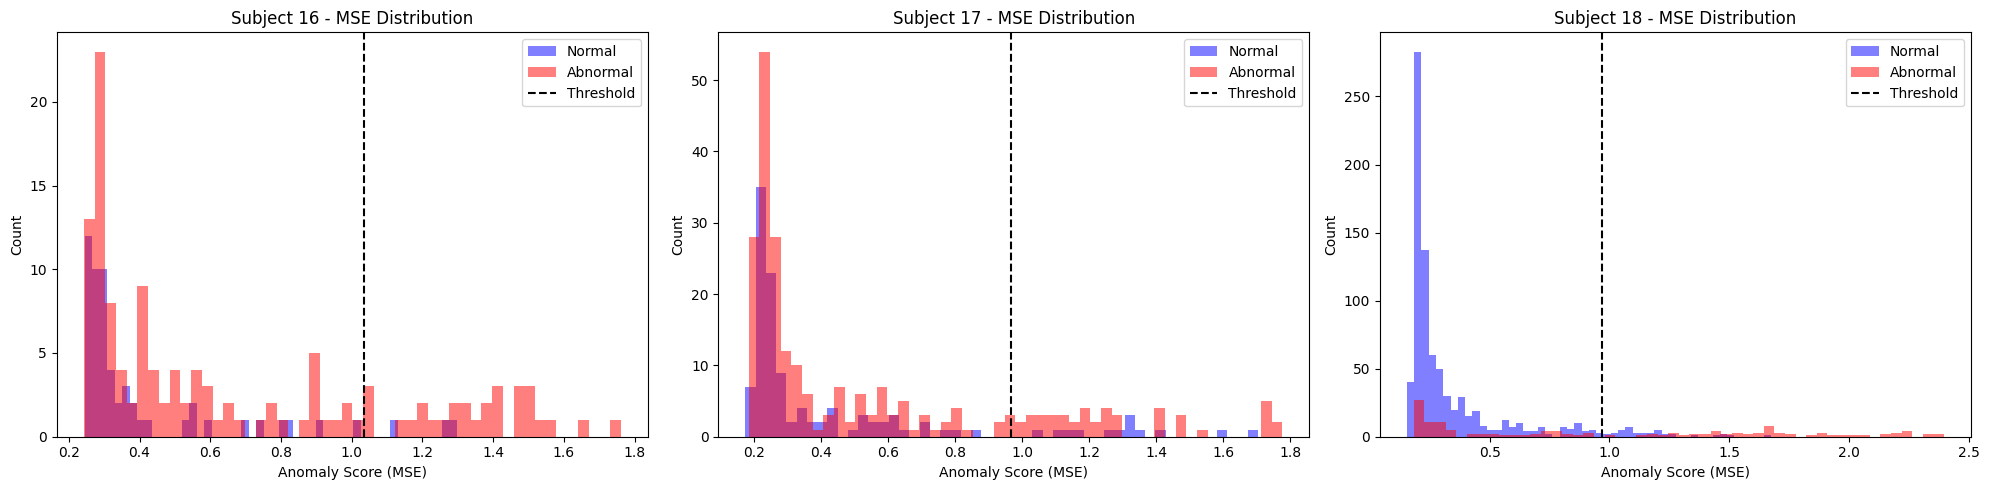

In [46]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
plt.hist(normal_scores_16, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_16, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_16 = np.percentile(normal_scores_16, 95)
plt.axvline(threshold_16, color='black', linestyle='--', label='Threshold')
plt.title('Subject 16 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
plt.hist(normal_scores_17, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_17, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_17 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_17, color='black', linestyle='--', label='Threshold')
plt.title('Subject 17 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
plt.hist(normal_scores_18, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_18, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_18 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_18, color='black', linestyle='--', label='Threshold')
plt.title('Subject 18 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
def create_error_df(normal_scores, abnormal_scores):
    return pd.DataFrame({
        'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
        'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
    })

error_df_16 = create_error_df(normal_scores_16, abnormal_scores_16)
error_df_17 = create_error_df(normal_scores_17, abnormal_scores_17)
error_df_18 = create_error_df(normal_scores_18, abnormal_scores_18)

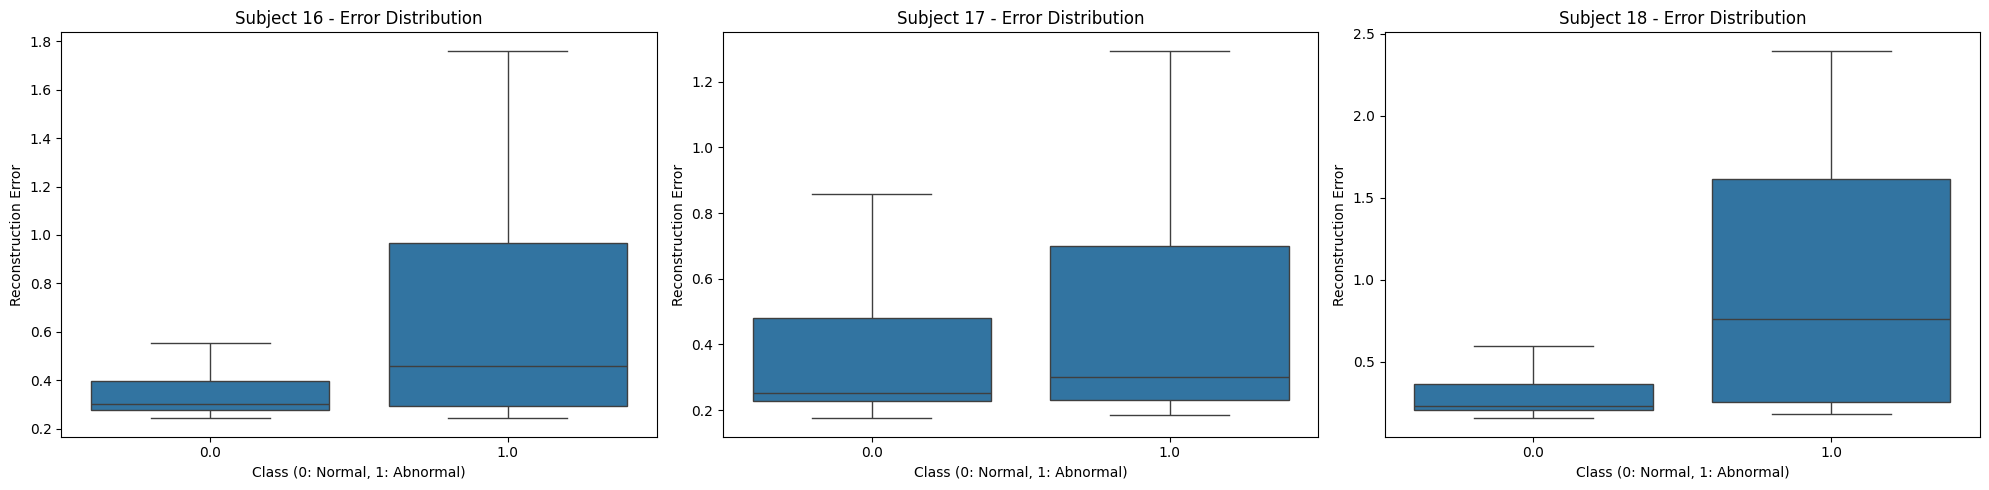

In [48]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_16, showfliers=False)
plt.title('Subject 16 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 2)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_17, showfliers=False)
plt.title('Subject 17 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 3)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_18, showfliers=False)
plt.title('Subject 18 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.tight_layout()
plt.show()

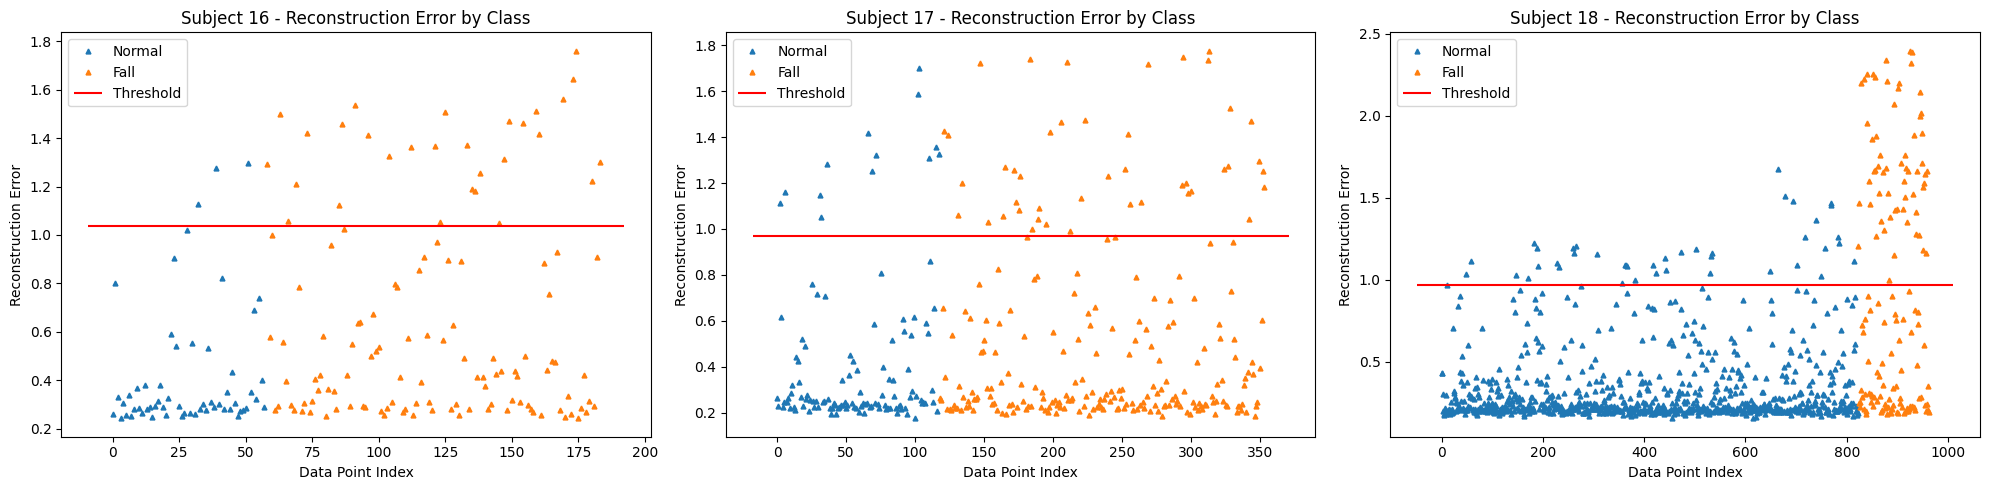

In [49]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
groups = error_df_16.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_16, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 16 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
groups = error_df_17.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_17, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 17 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
groups = error_df_18.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_18, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 18 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

plt.tight_layout()
plt.show()

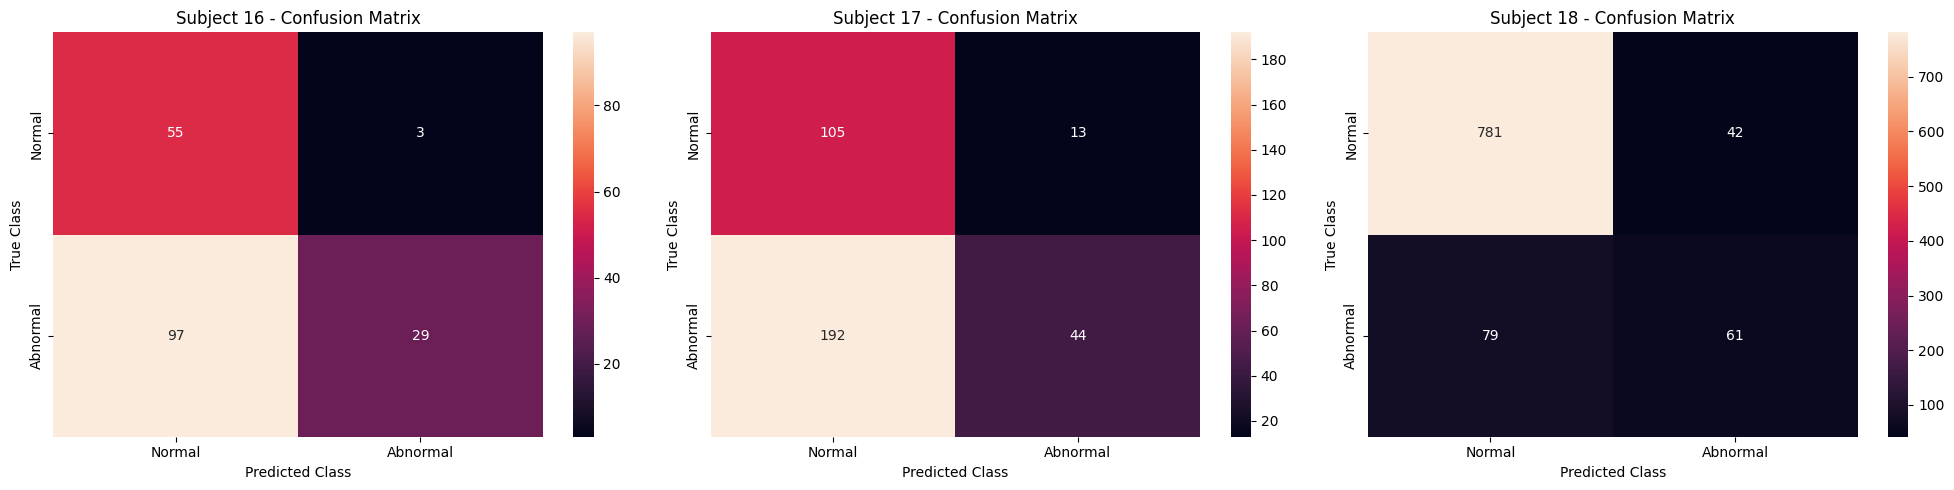

In [50]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
y_pred_16 = [1 if e > threshold_16 else 0 for e in error_df_16.reconstruction_error.values]
conf_matrix_16 = confusion_matrix(error_df_16.true_class, y_pred_16)
sns.heatmap(conf_matrix_16, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 16 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 17
plt.subplot(1, 3, 2)
y_pred_17 = [1 if e > threshold_17 else 0 for e in error_df_17.reconstruction_error.values]
conf_matrix_17 = confusion_matrix(error_df_17.true_class, y_pred_17)
sns.heatmap(conf_matrix_17, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 17 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 18
plt.subplot(1, 3, 3)
y_pred_18 = [1 if e > threshold_18 else 0 for e in error_df_18.reconstruction_error.values]
conf_matrix_18 = confusion_matrix(error_df_18.true_class, y_pred_18)
sns.heatmap(conf_matrix_18, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 18 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

In [51]:
for subject_id, error_df, threshold in [
    (16, error_df_16, threshold_16),
    (17, error_df_17, threshold_17),
    (18, error_df_18, threshold_18)
]:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    y_true = error_df.true_class.values
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'\nSubject {subject_id} Performance:')
    print(f'Accuracy Score : {accuracy:.4f}')
    print(f'Precision     : {precision:.4f}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1 Score      : {f1:.4f}')


Subject 16 Performance:
Accuracy Score : 0.4565
Precision     : 0.9062
Recall        : 0.2302
F1 Score      : 0.3671

Subject 17 Performance:
Accuracy Score : 0.4209
Precision     : 0.7719
Recall        : 0.1864
F1 Score      : 0.3003

Subject 18 Performance:
Accuracy Score : 0.8744
Precision     : 0.5922
Recall        : 0.4357
F1 Score      : 0.5021
